## **前處理自gm27開始獨立出來(No one-hot and Normalization this time)**

## Import Libraries

In [ ]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib 
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import tensorflow as tf
print("tensorflow version: {}".format(tf.__version__))

#misc libraries
import random
import time
import os
import re

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.0.1
matplotlib version: 3.2.1
NumPy version: 1.18.3
SciPy version: 1.4.1
IPython version: 7.12.0
scikit-learn version: 0.22.1
tensorflow version: 2.1.0
-------------------------


In [ ]:
#Deep Learning Tools
from tensorflow.keras import models, layers, regularizers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

#Common Model Algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from sklearn import feature_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import SMOTENC


#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import seaborn as sns
import pandas_profiling as pp
from sklearn.inspection import permutation_importance

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set()
#pylab.rcParams['figure.figsize'] = 12,8

Using TensorFlow backend.


## Self Def Functions

In [ ]:
def Sort_Columns(ColNames):
  Parameter = list(map(lambda x: x.rsplit('_',1)[1] if len(x.rsplit('_',1))>1 else x,
                       ColNames))
  Sorted_Tuple = sorted(zip(Parameter,ColNames),key = lambda x:x[0])
  return [col for (index,col) in Sorted_Tuple]

In [ ]:
def Pretty_Print(ColNames,FeaturesName,Print_Col = 3, length = 100):
  ##Self Define ColName Print Format
  def Pretty_ColName(ColName):
    ColName_ = ColName.rsplit('_',1)
    ColName_ = ColName_[::-1]

    if len(ColName_)>1:
      Number = ColName_[0]

      if re.match(r'[A-Z]+',Number):
        Number = ' '*5
        ColName_[1] = ColName
      elif re.match(r'[0-9]+[A-Z]',Number):
        Number = Number.rjust(5)
      else:
        Number = Number.rjust(4).ljust(5)
      
      ColName_[0] = Number

    else:
      ColName_.insert(0,' '*5)
    
    ColName_[1] = ColName_[1].ljust(25)

    return '{} : {}'.format(*ColName_)
  ##
  ColNames = Sort_Columns(ColNames)

  Print_List = []
  index = 0
  while index <len(ColNames):
    Print_List.append(ColNames[index:index+Print_Col])
    index += Print_Col

  print('-'*length)
  print(FeaturesName.center(length))
  print('-'*length)
  print('\n'.join([' '.join([Pretty_ColName(item) for item in row]) for row in Print_List]))

In [ ]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
 
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

## Import Data & Create Input

In [ ]:
file_root = 'D:\\ShaoTing\\data\\raw_done\\'
start_year = 1992
end_year = 2019

read_dictionary = np.load('datatype_object.npy',allow_pickle='TRUE').item()

file_list = os.listdir(file_root)
file_list = [filename for filename in file_list if filename.endswith('.csv')]
file_list = np.sort(file_list)
file_dict = {}
for filename in file_list:
  Year = int(filename.strip('.csv').strip('final_'))
  if Year in range(start_year,end_year+1):4 
    print('-'*25)
    print(Year)

    file_dict[Year] = pd.read_csv(file_root+filename, low_memory = False, encoding='latin-1', dtype = read_dictionary)
    
    print('Size: {}'.format(file_dict[Year].shape))

-------------------------
1992
Size: (263717, 77)
-------------------------
1993
Size: (240777, 77)
-------------------------
1994
Size: (261902, 77)
-------------------------
1995
Size: (235962, 77)
-------------------------
1996
Size: (257853, 77)
-------------------------
1997
Size: (226837, 77)
-------------------------
1998
Size: (245127, 77)
-------------------------
1999
Size: (227942, 77)
-------------------------
2000
Size: (241876, 77)
-------------------------
2001
Size: (225088, 77)
-------------------------
2002
Size: (237449, 77)
-------------------------
2003
Size: (225405, 77)
-------------------------
2004
Size: (242012, 77)
-------------------------
2005
Size: (234343, 77)
-------------------------
2006
Size: (241328, 77)
-------------------------
2007
Size: (241604, 77)
-------------------------
2008
Size: (254502, 77)
-------------------------
2009
Size: (243642, 77)
-------------------------
2010
Size: (252956, 77)
-------------------------
2011
Size: (240230, 77)


### LabelEncoding and StandardScaler

In [ ]:
ID = ['STATE_CODE_001','STRUCTURE_NUMBER_008']
Target = ['DECK_COND_058']
Common_Column = [col for col in list(file_dict[2017].columns) if col not in ID+Target]

df = file_dict[2017].copy()

DT_changed = ['SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060', 'CHANNEL_COND_061',
              'STRUCTURAL_EVAL_067', 'DECK_GEOMETRY_EVAL_068', 'UNDCLRENCE_EVAL_069',
              'WATERWAY_EVAL_071', 'APPR_ROAD_EVAL_072', 'YEAR_RECONSTRUCTED_106', 'SCOUR_CRITICAL_113']

df[DT_changed] = df[DT_changed].astype('object')

Cat_Cols = [col for col in Common_Column if df[col].dtype in ['object','str']]

Numerical_Cols = [col for col in Common_Column if df[col].dtype not in ['object','str']]

Pretty_Print(Cat_Cols,'Categorial Response Number : {}'.format(len(Cat_Cols)))

Pretty_Print(Numerical_Cols,'Numerical Response Number : {}'.format(len(Numerical_Cols)))

----------------------------------------------------------------------------------------------------
                                  Categorial Response Number : 40                                   
----------------------------------------------------------------------------------------------------
 005B : ROUTE_PREFIX               005C : SERVICE_LEVEL              021  : MAINTENANCE              
 026  : FUNCTIONAL_CLASS           031  : DESIGN_LOAD                036A : RAILINGS                 
 036B : TRANSITIONS                036C : APPR_RAIL                  036D : APPR_RAIL_END            
 037  : HISTORY                    038  : NAVIGATION                 041  : OPEN_CLOSED_POSTED       
 042A : SERVICE_ON                 042B : SERVICE_UND                043A : STRUCTURE_KIND           
 043B : STRUCTURE_TYPE             054A : VERT_CLR_UND_REF           055A : LAT_UND_REF              
 059  : SUPERSTRUCTURE_COND        060  : SUBSTRUCTURE_COND          061  : CHANNEL_C

In [ ]:
for Year, df in file_dict.items():
    print('-'*25)
    print(Year)
    
    df[Numerical_Cols] = StandardScaler().fit_transform(df[Numerical_Cols])
    
    for col in Cat_Cols:
        df[col] = LabelEncoder().fit_transform(df[col])+1
    
    columns = df.select_dtypes(include = 'float').columns
    df[columns] = df[columns].apply(pd.to_numeric, downcast = 'float')
    
    columns = df.select_dtypes(include = 'int').columns
    df[columns] = df[columns].apply(pd.to_numeric, downcast = 'integer')

    file_dict[Year] = df
    print('Size: {}'.format(file_dict[Year].shape))

-------------------------
1992
Size: (263717, 77)
-------------------------
1993
Size: (240777, 77)
-------------------------
1994
Size: (261902, 77)
-------------------------
1995
Size: (235962, 77)
-------------------------
1996
Size: (257853, 77)
-------------------------
1997
Size: (226837, 77)
-------------------------
1998
Size: (245127, 77)
-------------------------
1999
Size: (227942, 77)
-------------------------
2000
Size: (241876, 77)
-------------------------
2001
Size: (225088, 77)
-------------------------
2002
Size: (237449, 77)
-------------------------
2003
Size: (225405, 77)
-------------------------
2004
Size: (242012, 77)
-------------------------
2005
Size: (234343, 77)
-------------------------
2006
Size: (241328, 77)
-------------------------
2007
Size: (241604, 77)
-------------------------
2008
Size: (254502, 77)
-------------------------
2009
Size: (243642, 77)
-------------------------
2010
Size: (252956, 77)
-------------------------
2011
Size: (240230, 77)


In [ ]:
# Record all bridges
flag = 0
for df in file_dict.values():
    if flag==0:
        Names = set((df.STATE_CODE_001[i],df.STRUCTURE_NUMBER_008[i]) for i in range(len(df)))
        flag = 1
    else:
        ch1 = set((df.STATE_CODE_001[i],df.STRUCTURE_NUMBER_008[i]) for i in range(len(df)))
        Names = Names.union(ch1)

In [ ]:
flag = 0
df_dict = {key: pd.DataFrame(Names, columns=ID) for key in (Target+Common_Column)}

for Year, df_raw in file_dict.items():
    print('-'*25)
    print(Year)
    
    df_raw.STATE_CODE_001 = df_raw.STATE_CODE_001.astype('int')
    df_raw = df_raw.sort_values(by=['STATE_CODE_001','STRUCTURE_NUMBER_008'],ascending=[True,True])
    ch1 = set((df_raw.STATE_CODE_001[i],df_raw.STRUCTURE_NUMBER_008[i]) for i in range(len(df_raw)))
  
    for col, df_input in df_dict.items():

        if flag == 0:
            df_input = df_input.sort_values(by=['STATE_CODE_001','STRUCTURE_NUMBER_008'],ascending=[True,True]).reset_index(drop = True)
            df_input['id_tuple'] = df_input[['STATE_CODE_001','STRUCTURE_NUMBER_008']].apply(tuple, axis = 1)

        df_input[str(Year)] = np.nan
        df_input.loc[df_input.id_tuple.isin(list(ch1)), str(Year)] = df_raw[col].to_numpy()

        df_dict[col] = df_input
  
    flag = 1

-------------------------
1992
-------------------------
1993
-------------------------
1994
-------------------------
1995
-------------------------
1996
-------------------------
1997
-------------------------
1998
-------------------------
1999
-------------------------
2000
-------------------------
2001
-------------------------
2002
-------------------------
2003
-------------------------
2004
-------------------------
2005
-------------------------
2006
-------------------------
2007
-------------------------
2008
-------------------------
2009
-------------------------
2010
-------------------------
2011
-------------------------
2012
-------------------------
2013
-------------------------
2014
-------------------------
2015
-------------------------
2016
-------------------------
2017
-------------------------
2018
-------------------------
2019


In [ ]:
del file_dict

### 刪掉ID

In [ ]:
for col,df in df_dict.items():
  
    if 'id_tuple' in df.columns:
        df.drop(columns = ID+['id_tuple'], inplace=True)

    if col in Cat_Cols:
        df = df.apply(pd.to_numeric, downcast = 'integer')
    else:
        df = df.apply(pd.to_numeric, downcast = 'float')

    df_dict[col] = df

### 紀錄橋梁檢測時間

In [ ]:
df = df_dict['DECK_COND_058']

ins_yr = np.empty(df.shape)
ins_yr[:] = np.nan
ins_yr = pd.DataFrame(ins_yr, columns=df.columns)

for col in df.columns:
    ins_yr.loc[df[col].notnull(), col] = int(col)

## Case 1，t=0.35

In [ ]:
model_dict = {k:v.copy() for k,v in df_dict.items()}

In [ ]:
year = 1999
depth = 1
threshold = 0.2
skip_limit = 1

skip_times = np.zeros([len(Names), 1])
mat_dict_11 = {}
num_data_11 = pd.DataFrame(columns=['Training', 'Training Deficient', 'Testing', 'Testing Deficient'])
result_11 = pd.DataFrame(columns=['recall', 'error', 'err_ratio', 'inspection_saved', 'inspection_saved_ratio','deficient_bridges', 'total_bridges'])

In [ ]:
for col, df in model_dict.items():
    df.loc[:, str(year):] = np.nan
    model_dict[col] = df

In [ ]:
id(model_dict['DECK_COND_058']) == id(df_dict['DECK_COND_058'])

False

In [ ]:
while year <= end_year:
    print('-'*25)
    print(year)

    if year == end_year:
        ins = ins_yr.copy()
    else:
        ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]
        
    v = ins.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)
    total_bridges = ins.loc[ins[str(year)] == year].shape[0]

    if year == end_year:
        cond = df_dict['DECK_COND_058'].copy()
    else:
        cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year+1))]

    v = cond.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

    ignore_index = ins.index[(ins[str(year)] == year) & (ins.count(axis=1) <= depth)]

  #======Generating Data======

    X_train = pd.DataFrame()
    X_test  = pd.DataFrame()

    for col, df in model_dict.items():

        #Moving to the Right
        df = df.iloc[:,:df.columns.get_loc(str(year))]
        v = df.values
        a = (~np.isnan(v)).argsort(1, kind='mergesort')

        df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
        #-------------------

        df_train = df.loc[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & (cond[str(year)] <= cond[str(year - 1)])]
        df_test  = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth)]

        if col == 'DECK_COND_058':
            y_train = np.where(df_train.iloc[:,-1] <= 6, 1, 0)
            old_cond = df_test.iloc[:,-1]
        else:
            X_train[col] = df_train.iloc[:,-2]
            X_test[col]  = df_test.iloc[:,-1]
      

    num_deficient = np.sum(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year), str(year)] <= 4)
    y_test = np.where(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth), str(year)] <= 4, 1, 0)
    print("Training Set: ", X_train.shape, y_train.shape, "Deficient: ", np.sum(y_train))
    print("Testing  Set: ", X_test.shape,  y_test.shape,  "Deficient: ", np.sum(y_test))
    num_data_11.loc[year] = [len(y_train), np.sum(y_train), len(y_test), np.sum(y_test)]

    #==========Oversampling==========

    #sm = SMOTENC(sampling_strategy='not majority', categorical_features = X_train.columns.isin(Cat_Cols), random_state=77)
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    rus = RandomUnderSampler(random_state=77)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    unique, counts = np.unique(y_train_res, return_counts=True)
    print(dict(zip(unique, counts)))
    
    X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
    X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

    X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
    X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

    chch1 = set(X_train_res.columns.values)
    chch2 = set(X_test_res.columns.values)
    
    mutual = chch1.intersection(chch2)
    
    X_train_res = X_train_res[mutual]
    X_test_res  = X_test_res[mutual]

    print(X_train_res.shape, X_test_res.shape)
    
    #======Train/Predict======
    model_RF = RandomForestClassifier(n_estimators = 100, random_state = 77)
    model_RF.fit(X_train_res, y_train_res)

    y_scores = model_RF.predict_proba(X_test_res)[:,1]
    y_pred = np.array([1 if score >= threshold else 0 for score in y_scores])
    mat_dict_11[year] = confusion_matrix(y_test, y_pred)
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

    #======skip and redo======
    skip_index = []
    redo_index = []
    error = 0

    for jj, item in enumerate(y_pred):
        ii = X_test.index.values[jj]

        if (item == 0) & (skip_times[ii] < skip_limit):
            skip_index.append(ii)
            skip_times[ii] += 1
            
            if (item == 0) & (y_test[jj] == 1):
                error += 1
            
        else:
            redo_index.append(ii)
            skip_times[ii] = 0
            
    #======record======
    err_ratio = error/num_deficient
    inspection_saved = len(skip_index)
    ins_saved_ratio = len(skip_index)/total_bridges
    
    print("Error: %d, Error rate: %.6f, Ins_saved: %d, Ratio = %.4f" % (error, err_ratio, inspection_saved, ins_saved_ratio))
    result_11.loc[year] = [recall_score(y_test, y_pred), error, err_ratio, inspection_saved, ins_saved_ratio, num_deficient, total_bridges]

    #======Update======

    for col, df in model_dict.items():

        df.iloc[redo_index, df.columns.get_loc(str(year))]   = df_dict[col].iloc[redo_index, df.columns.get_loc(str(year))]
        df.iloc[ignore_index, df.columns.get_loc(str(year))] = df_dict[col].iloc[ignore_index, df.columns.get_loc(str(year))]

        if col == 'DECK_COND_058':
            df.iloc[skip_index, df.columns.get_loc(str(year))] = old_cond.loc[old_cond.index.isin(skip_index)]
        else:
            df.iloc[skip_index, df.columns.get_loc(str(year))] = X_test.loc[X_test.index.isin(skip_index), col]

        model_dict[col] = df

    year += 1

-------------------------
1999
Training Set:  (248201, 74) (248201,) Deficient:  110516
Testing  Set:  (215219, 74) (215219,) Deficient:  16061
{0: 110516, 1: 110516}
(221032, 413) (215219, 413)
Precision = 0.0958, Recall = 0.9965, f1 = 0.1747
Error: 57, Error rate: 0.003425, Ins_saved: 48095, Ratio = 0.2110
-------------------------
2000
Training Set:  (247594, 74) (247594,) Deficient:  112735
Testing  Set:  (226619, 74) (226619,) Deficient:  15490
{0: 112735, 1: 112735}
(225470, 407) (226619, 407)
Precision = 0.0892, Recall = 0.9950, f1 = 0.1637
Error: 66, Error rate: 0.004086, Ins_saved: 45630, Ratio = 0.1887
-------------------------
2001
Training Set:  (282740, 74) (282740,) Deficient:  128881
Testing  Set:  (204916, 74) (204916,) Deficient:  14439
{0: 128881, 1: 128881}
(257762, 410) (204916, 410)
Precision = 0.0922, Recall = 0.9946, f1 = 0.1687
Error: 26, Error rate: 0.001654, Ins_saved: 17849, Ratio = 0.0793
-------------------------
2002
Training Set:  (280685, 74) (280685,) D

In [ ]:
# result_11.to_csv('D:\\ShaoTing\\result\\\For_Paper\\result_1035.csv', index = False)
result_11

,recall,error,err_ratio,inspection_saved,inspection_saved_ratio,deficient_bridges,total_bridges
1999,0.996451,57.0,0.003425,48095.0,0.210997,16643.0,227942.0
2000,0.995029,66.0,0.004086,45630.0,0.188650,16151.0,241876.0
2001,0.994598,26.0,0.001654,17849.0,0.079298,15720.0,225088.0
2002,0.994565,23.0,0.001472,20564.0,0.086604,15625.0,237449.0
2003,0.996867,22.0,0.001477,33554.0,0.148861,14897.0,225405.0
2004,0.996585,42.0,0.002687,41435.0,0.171211,15629.0,242012.0
2005,0.997339,19.0,0.001250,25420.0,0.108473,15204.0,234343.0
2006,0.996729,13.0,0.000835,25215.0,0.104484,15574.0,241328.0
2007,0.997846,19.0,0.001196,36922.0,0.152820,15888.0,241604.0
2008,0.997323,25.0,0.001572,39613.0,0.155649,15903.0,254502.0


In [ ]:
num_data_11

,Training,Training Deficient,Testing,Testing Deficient
1999,248201,110516,215219,16061
2000,247594,112735,226619,15490
2001,282740,128881,204916,14439
2002,280685,130153,225048,15087
2003,304211,141371,217532,14682
2004,300091,140481,235163,15520
2005,322822,150683,218740,14656
2006,319108,149681,231406,15288
2007,328696,154689,235754,15784
2008,330109,156227,245591,15690


In [ ]:
print(np.mean(result_11.err_ratio)*100)
print(np.mean(result_11.inspection_saved_ratio)*100)

0.231470970761767
13.521089548834988


--------------------------------------------------
1999


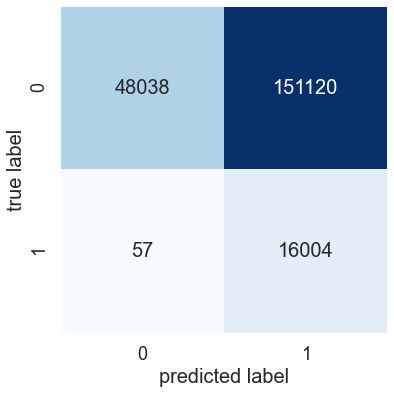

--------------------------------------------------
2000


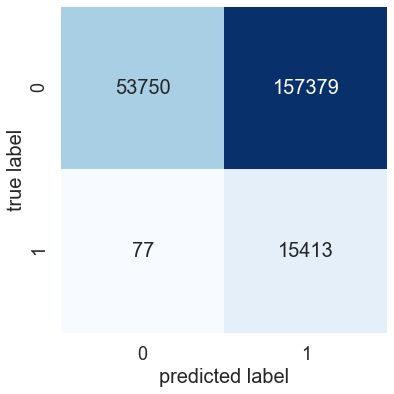

--------------------------------------------------
2001


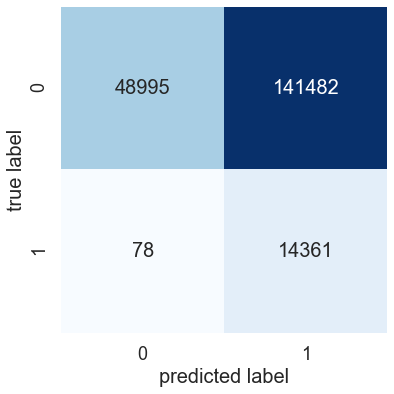

--------------------------------------------------
2002


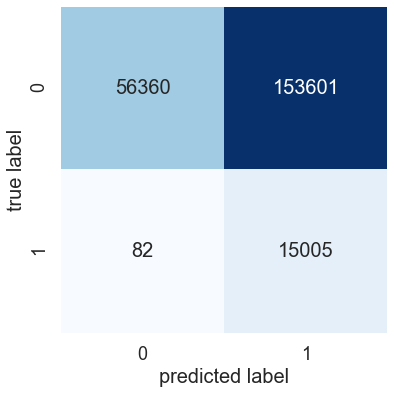

--------------------------------------------------
2003


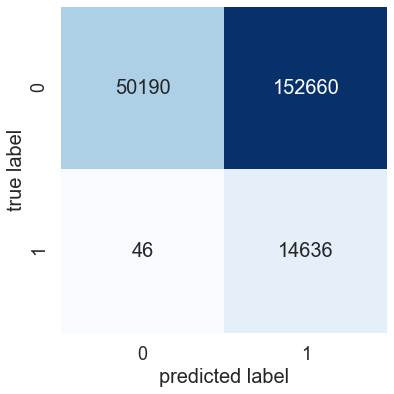

--------------------------------------------------
2004


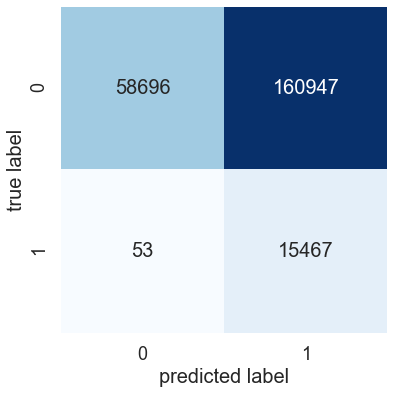

--------------------------------------------------
2005


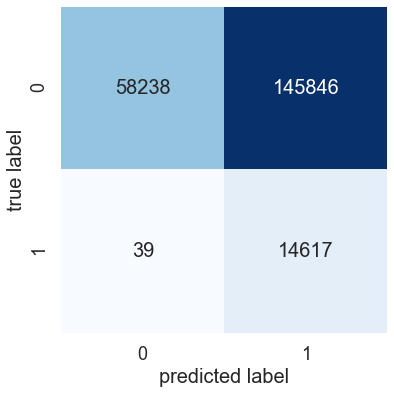

--------------------------------------------------
2006


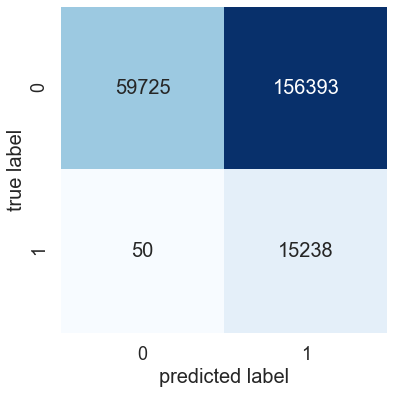

--------------------------------------------------
2007


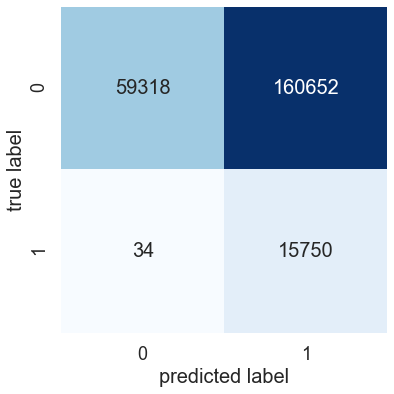

--------------------------------------------------
2008


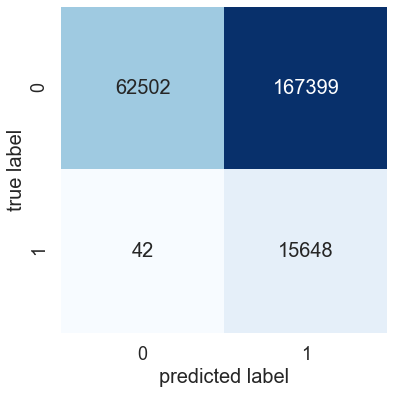

--------------------------------------------------
2009


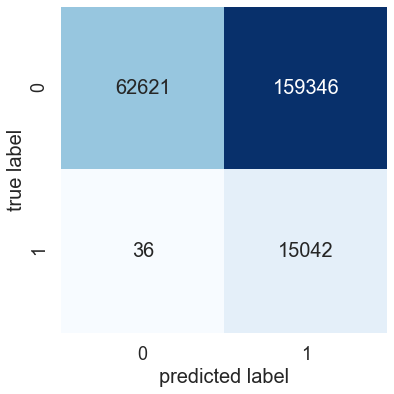

--------------------------------------------------
2010


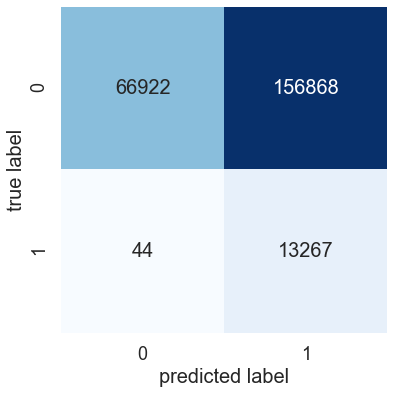

--------------------------------------------------
2011


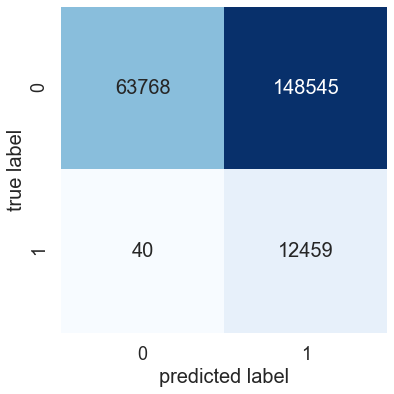

--------------------------------------------------
2012


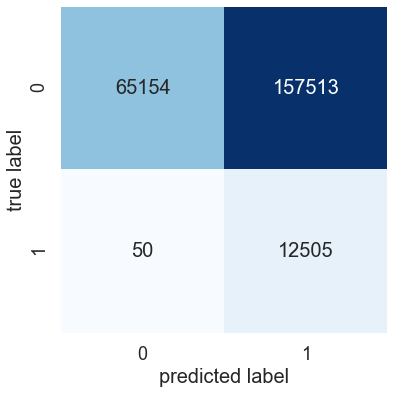

--------------------------------------------------
2013


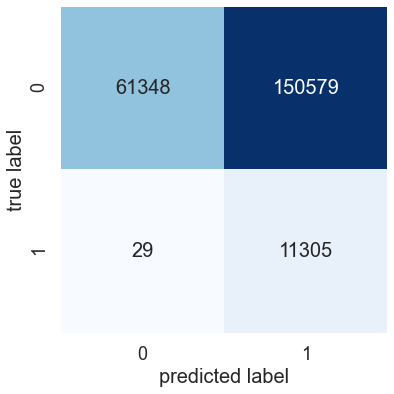

--------------------------------------------------
2014


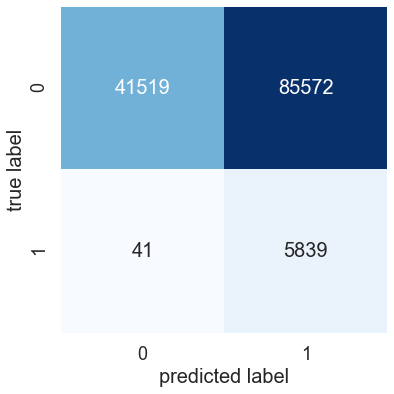

--------------------------------------------------
2015


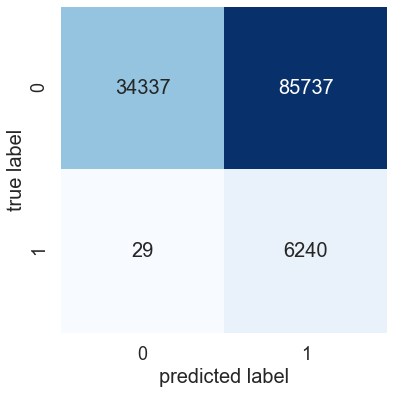

--------------------------------------------------
2016


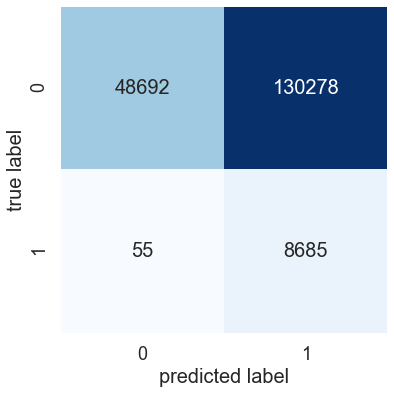

--------------------------------------------------
2017


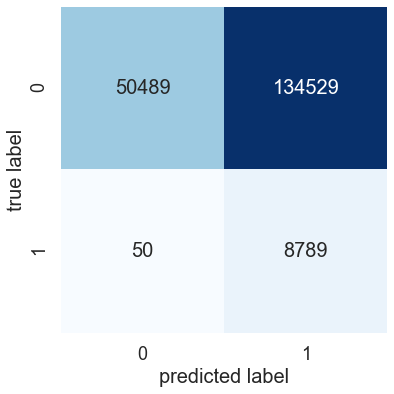

--------------------------------------------------
2018


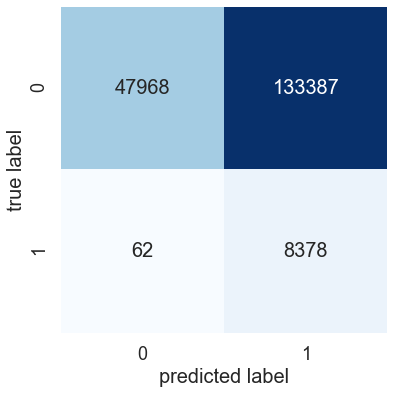

--------------------------------------------------
2019


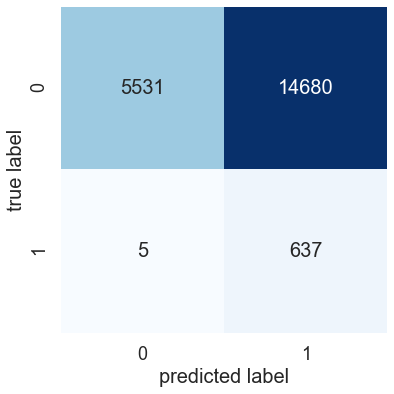

In [ ]:
for year, mat in mat_dict_11.items():
    print('-'*50)
    print(year)

    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

## Case 1，t=0.5

In [ ]:
model_dict = {k:v.copy() for k,v in df_dict.items()}

In [ ]:
year = 1999
depth = 1
threshold = 0.5
skip_limit = 1

skip_times = np.zeros([len(Names), 1])
mat_dict_12 = {}
num_data_12 = pd.DataFrame(columns=['Training', 'Training Deficient', 'Testing', 'Testing Deficient'])
result_12 = pd.DataFrame(columns=['recall', 'error', 'err_ratio', 'inspection_saved', 'inspection_saved_ratio','deficient_bridges', 'total_bridges'])

In [ ]:
for col, df in model_dict.items():
    df.loc[:, str(year):] = np.nan
    model_dict[col] = df

In [ ]:
id(model_dict['DECK_COND_058']) == id(df_dict['DECK_COND_058'])

False

In [ ]:
while year <= end_year:
    print('-'*25)
    print(year)

    if year == end_year:
        ins = ins_yr.copy()
    else:
        ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]
        
    v = ins.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)
    total_bridges = ins.loc[ins[str(year)] == year].shape[0]

    if year == end_year:
        cond = df_dict['DECK_COND_058'].copy()
    else:
        cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year+1))]

    v = cond.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

    ignore_index = ins.index[(ins[str(year)] == year) & (ins.count(axis=1) <= depth)]

  #======Generating Data======

    X_train = pd.DataFrame()
    X_test  = pd.DataFrame()

    for col, df in model_dict.items():

        #Moving to the Right
        df = df.iloc[:,:df.columns.get_loc(str(year))]
        v = df.values
        a = (~np.isnan(v)).argsort(1, kind='mergesort')

        df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
        #-------------------

        df_train = df.loc[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & (cond[str(year)] <= cond[str(year - 1)])]
        df_test  = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth)]

        if col == 'DECK_COND_058':
            y_train = np.where(df_train.iloc[:,-1] <= 6, 1, 0)
            old_cond = df_test.iloc[:,-1]
        else:
            X_train[col] = df_train.iloc[:,-2]
            X_test[col]  = df_test.iloc[:,-1]
      
    num_deficient = np.sum(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year), str(year)] <= 4)
    y_test = np.where(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth), str(year)] <= 4, 1, 0)
    print("Training Set: ", X_train.shape, y_train.shape, "Deficient: ", np.sum(y_train))
    print("Testing  Set: ", X_test.shape,  y_test.shape,  "Deficient: ", np.sum(y_test))
    num_data_12.loc[year] = [len(y_train), np.sum(y_train), len(y_test), np.sum(y_test)]
    

    #==========Oversampling==========

    #sm = SMOTENC(sampling_strategy='not majority', categorical_features = X_train.columns.isin(Cat_Cols), random_state=77)
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    rus = RandomUnderSampler(random_state=77)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    unique, counts = np.unique(y_train_res, return_counts=True)
    print(dict(zip(unique, counts)))
    
    X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
    X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

    X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
    X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

    chch1 = set(X_train_res.columns.values)
    chch2 = set(X_test_res.columns.values)
    
    mutual = chch1.intersection(chch2)
    
    X_train_res = X_train_res[mutual]
    X_test_res  = X_test_res[mutual]

    print(X_train_res.shape, X_test_res.shape)
    
    #======Train/Predict======
    model_RF = RandomForestClassifier(n_estimators = 100, random_state = 77)
    model_RF.fit(X_train_res, y_train_res)

    y_scores = model_RF.predict_proba(X_test_res)[:,1]
    y_pred = np.array([1 if score >= threshold else 0 for score in y_scores])
    mat_dict_12[year] = confusion_matrix(y_test, y_pred)
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

    #======skip and redo======
    skip_index = []
    redo_index = []
    error = 0

    for jj, item in enumerate(y_pred):
        ii = X_test.index.values[jj]

        if (item == 0) & (skip_times[ii] < skip_limit):
            skip_index.append(ii)
            skip_times[ii] += 1
            
            if (item == 0) & (y_test[jj] == 1):
                error += 1
            
        else:
            redo_index.append(ii)
            skip_times[ii] = 0
            
    #======record======
    err_ratio = error/num_deficient
    inspection_saved = len(skip_index)
    ins_saved_ratio = len(skip_index)/total_bridges
    
    print("Error: %d, Error rate: %.6f, Ins_saved: %d, Ratio = %.4f" % (error, err_ratio, inspection_saved, ins_saved_ratio))
    result_12.loc[year] = [recall_score(y_test, y_pred), error, err_ratio, inspection_saved, ins_saved_ratio, num_deficient, total_bridges]

    #======Update======

    for col, df in model_dict.items():

        df.iloc[redo_index, df.columns.get_loc(str(year))]   = df_dict[col].iloc[redo_index, df.columns.get_loc(str(year))]
        df.iloc[ignore_index, df.columns.get_loc(str(year))] = df_dict[col].iloc[ignore_index, df.columns.get_loc(str(year))]

        if col == 'DECK_COND_058':
            df.iloc[skip_index, df.columns.get_loc(str(year))] = old_cond.loc[old_cond.index.isin(skip_index)]
        else:
            df.iloc[skip_index, df.columns.get_loc(str(year))] = X_test.loc[X_test.index.isin(skip_index), col]

        model_dict[col] = df

    year += 1

-------------------------
1999
Training Set:  (248201, 74) (248201,) Deficient:  110516
Testing  Set:  (215219, 74) (215219,) Deficient:  16061
{0: 110516, 1: 110516}
(221032, 413) (215219, 413)
Precision = 0.1447, Recall = 0.9509, f1 = 0.2512
Error: 788, Error rate: 0.049063, Ins_saved: 109660, Ratio = 0.4811
-------------------------
2000
Training Set:  (247594, 74) (247594,) Deficient:  109088
Testing  Set:  (226619, 74) (226619,) Deficient:  15490
{0: 109088, 1: 109088}
(218176, 409) (226619, 409)
Precision = 0.1375, Recall = 0.9321, f1 = 0.2397
Error: 868, Error rate: 0.056036, Ins_saved: 101556, Ratio = 0.4199
-------------------------
2001
Training Set:  (282740, 74) (282740,) Deficient:  124641
Testing  Set:  (204916, 74) (204916,) Deficient:  14439
{0: 124641, 1: 124641}
(249282, 412) (204916, 412)
Precision = 0.1429, Recall = 0.9260, f1 = 0.2475
Error: 384, Error rate: 0.026595, Ins_saved: 32925, Ratio = 0.1463
-------------------------
2002
Training Set:  (280685, 74) (28068

In [ ]:
# result_12.to_csv('D:\\ShaoTing\\result\\\For_Paper\\result_105.csv', index = False)
result_12

,recall,error,err_ratio,inspection_saved,inspection_saved_ratio,deficient_bridges,total_bridges
1999,0.950937,788.0,0.049063,109660.0,0.481087,16061.0,227942.0
2000,0.932150,868.0,0.056036,101556.0,0.419868,15490.0,241876.0
2001,0.925964,384.0,0.026595,32925.0,0.146276,14439.0,225088.0
2002,0.928945,350.0,0.023199,37635.0,0.158497,15087.0,237449.0
2003,0.939995,561.0,0.038210,82944.0,0.367978,14682.0,225405.0
2004,0.937178,643.0,0.041430,91546.0,0.378270,15520.0,242012.0
2005,0.936749,402.0,0.027429,42545.0,0.181550,14656.0,234343.0
2006,0.934785,387.0,0.025314,46803.0,0.193939,15288.0,241328.0
2007,0.940763,558.0,0.035352,85325.0,0.353161,15784.0,241604.0
2008,0.949904,447.0,0.028489,86653.0,0.340481,15690.0,254502.0


In [ ]:
print(np.mean(result_12.err_ratio)*100)
print(np.mean(result_12.inspection_saved_ratio)*100)

3.7147470068466726
28.028785583319376


--------------------------------------------------
1999


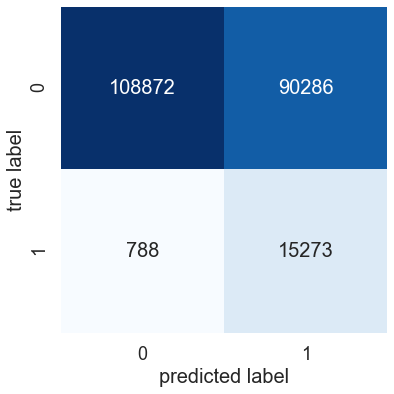

--------------------------------------------------
2000


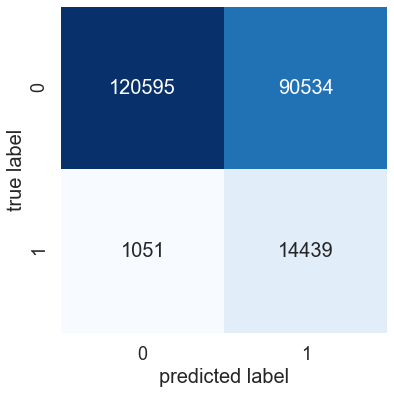

--------------------------------------------------
2001


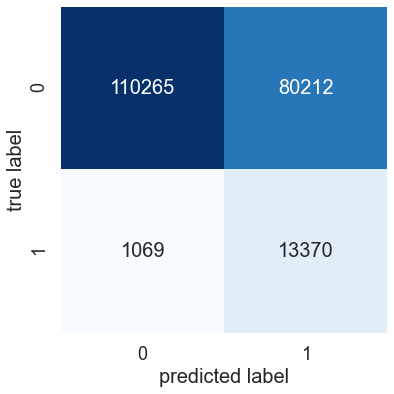

--------------------------------------------------
2002


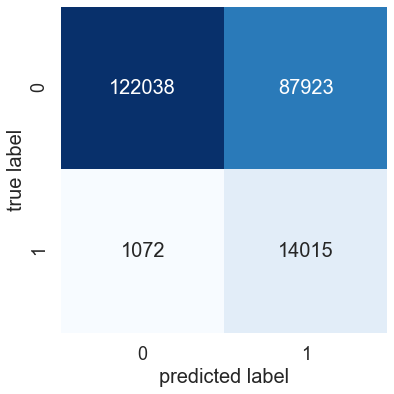

--------------------------------------------------
2003


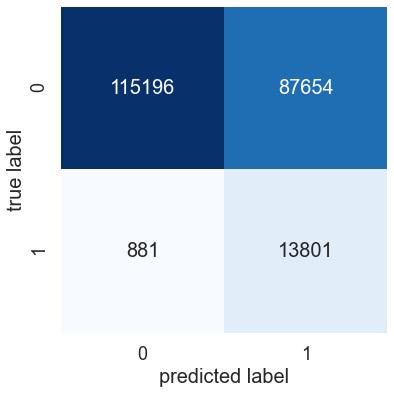

--------------------------------------------------
2004


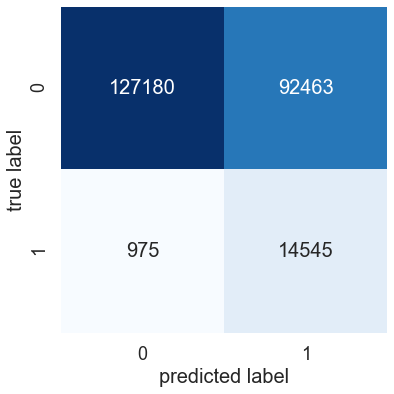

--------------------------------------------------
2005


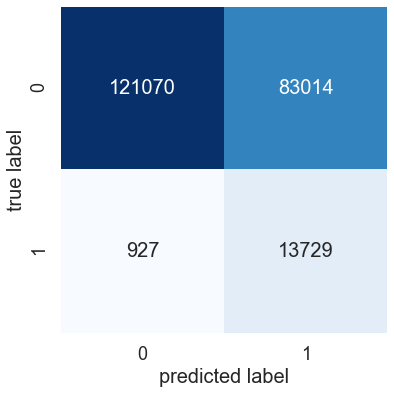

--------------------------------------------------
2006


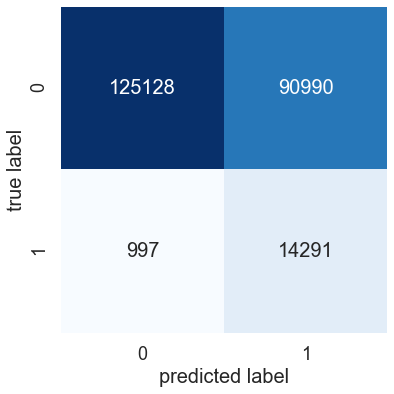

--------------------------------------------------
2007


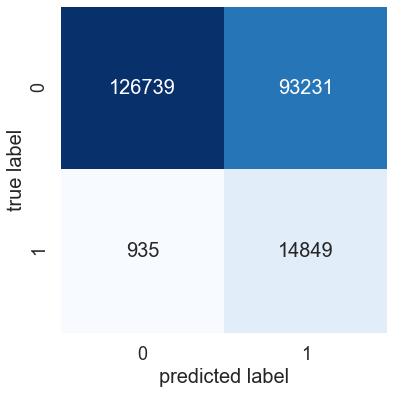

--------------------------------------------------
2008


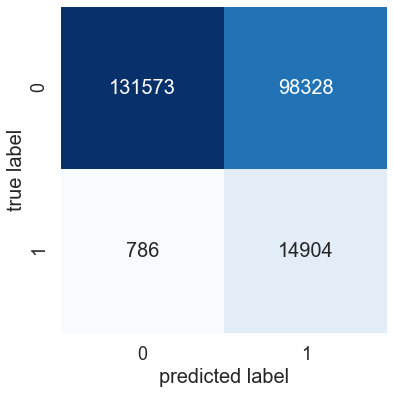

--------------------------------------------------
2009


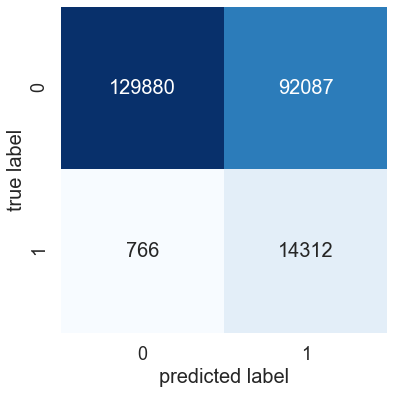

--------------------------------------------------
2010


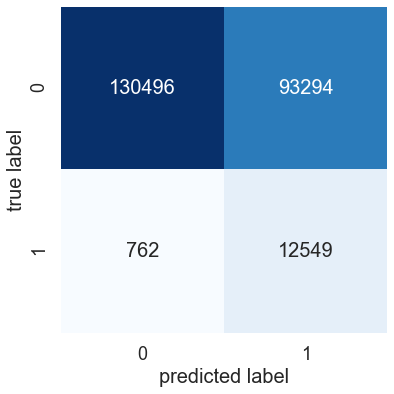

--------------------------------------------------
2011


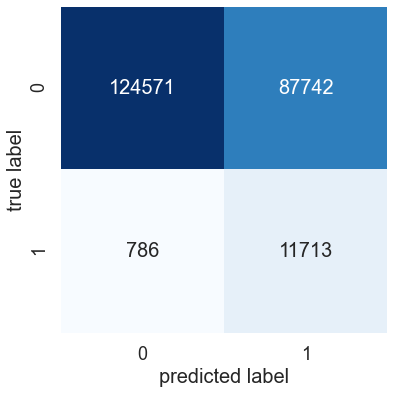

--------------------------------------------------
2012


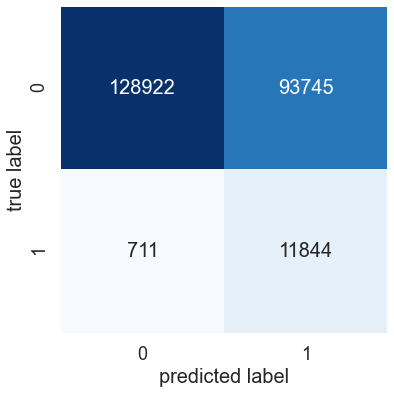

--------------------------------------------------
2013


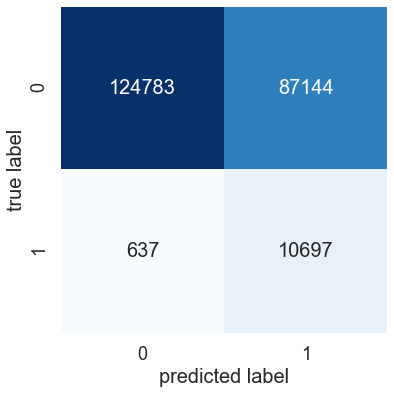

--------------------------------------------------
2014


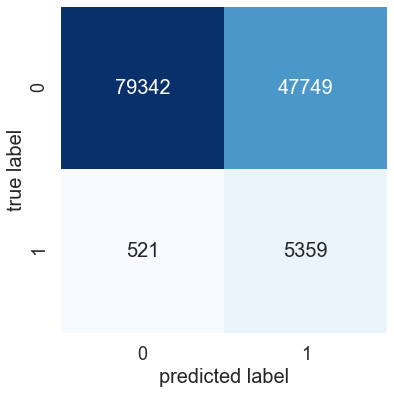

--------------------------------------------------
2015


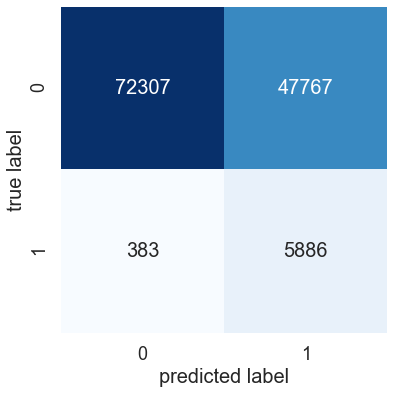

--------------------------------------------------
2016


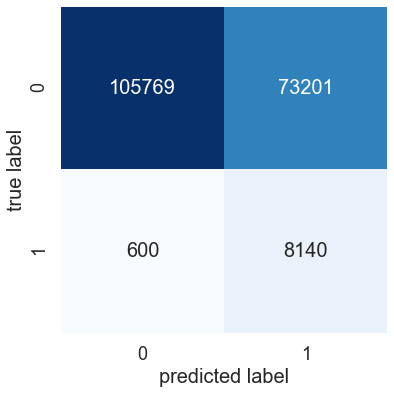

--------------------------------------------------
2017


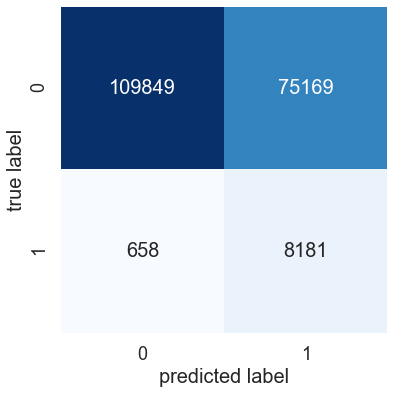

--------------------------------------------------
2018


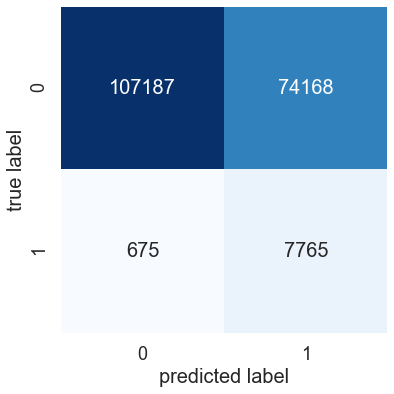

--------------------------------------------------
2019


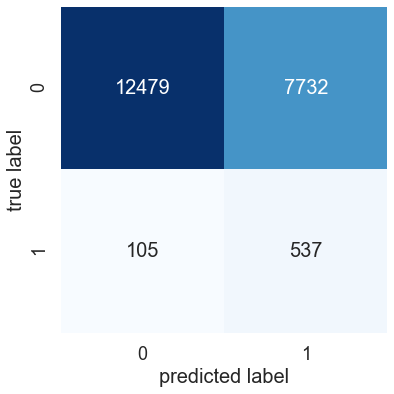

In [ ]:
for year, mat in mat_dict_12.items():
    print('-'*50)
    print(year)

    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

## Case 2，t=0.35

In [ ]:
model_dict = {k:v.copy() for k,v in df_dict.items()}

In [ ]:
year = 1999
depth = 2
threshold = 0.35
skip_limit = 1

skip_times = np.zeros([len(Names), 1])
mat_dict_21 = {}
num_data_21 = pd.DataFrame(columns=['Training', 'Training Deficient', 'Testing', 'Testing Deficient'])
result_21 = pd.DataFrame(columns=['recall', 'error', 'err_ratio', 'inspection_saved', 'inspection_saved_ratio','deficient_bridges', 'total_bridges'])

delta_Num = ['DETOUR_KILOS_019','ADT_029', 'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060',
             'CHANNEL_COND_061', 'OPERATING_RATING_064', 'INVENTORY_RATING_066','STRUCTURAL_EVAL_067',
             'DECK_GEOMETRY_EVAL_068', 'UNDCLRENCE_EVAL_069','POSTING_EVAL_070','WATERWAY_EVAL_071',
             'APPR_ROAD_EVAL_072','PERCENT_ADT_TRUCK_109', 'FUTURE_ADT_114']

Pretty_Print(delta_Num, 'Time-changing Features',2,62)

--------------------------------------------------------------
                    Time-changing Features                    
--------------------------------------------------------------
 019  : DETOUR_KILOS               029  : ADT                      
 059  : SUPERSTRUCTURE_COND        060  : SUBSTRUCTURE_COND        
 061  : CHANNEL_COND               064  : OPERATING_RATING         
 066  : INVENTORY_RATING           067  : STRUCTURAL_EVAL          
 068  : DECK_GEOMETRY_EVAL         069  : UNDCLRENCE_EVAL          
 070  : POSTING_EVAL               071  : WATERWAY_EVAL            
 072  : APPR_ROAD_EVAL             109  : PERCENT_ADT_TRUCK        
 114  : FUTURE_ADT               


In [ ]:
for col, df in model_dict.items():
    df.loc[:, str(year):] = np.nan
    model_dict[col] = df

In [ ]:
while year <= end_year:
    print('-'*25)
    print(year)
  
    if year == end_year:
        ins = ins_yr.copy()
    else:
        ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]

    v = ins.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)
    total_bridges = ins.loc[ins[str(year)] == year].shape[0]

    if year == end_year:
        cond = df_dict['DECK_COND_058'].copy()
    else:
        cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year+1))]

    v = cond.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

    idx_train = ins.index[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                        (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)])]

    idx_test  = ins.index[(ins[str(year)] == year) & (ins.count(axis=1) > depth) & (cond[str(year-1)] <= cond[str(year-2)])]

    ignore_index = set(ins.index) - set(idx_train) - set(idx_test)

  #======Generating Data======

    X_train = pd.DataFrame()
    X_test  = pd.DataFrame()

    for col, df in model_dict.items():

        #Moving to the Right
        df = df.iloc[:,:df.columns.get_loc(str(year))]
        v = df.values
        a = (~np.isnan(v)).argsort(1, kind='mergesort')

        df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
        #-------------------

        df_train = df.loc[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                          (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)])]

        df_test  = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) & (cond[str(year-1)] <= cond[str(year-2)])]

        if col == 'DECK_COND_058':
            y_train = np.where(df_train.iloc[:,-1] <= 6, 1, 0)
            old_cond = df_test.iloc[:,-1]
        else:
            if col in delta_Num:
                X_train[col] = df_train.iloc[:,-3:-1].mean(axis = 1)
                X_train[col + '_std']  = df_train.iloc[:,-3:-1].std(axis = 1)
                X_train[col + '_diff_1'] = np.subtract(df_train.iloc[:,-2],df_train.iloc[:,-3])

                X_test[col] = df_test.iloc[:,-2:].mean(axis = 1)
                X_test[col + '_std']  = df_test.iloc[:,-2:].std(axis = 1)
                X_test[col + '_diff_1'] = np.subtract(df_test.iloc[:,-1],df_test.iloc[:,-2])
            else:
                X_train[col] = df_train.iloc[:,-2]
                X_test[col]  = df_test.iloc[:,-1]
      

    num_deficient = np.sum(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year), str(year)] <= 4)
    y_test = np.where(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) &
                                                 (cond[str(year-1)] <= cond[str(year-2)]), str(year)] <= 4, 1, 0)
    print("Training Set: ", X_train.shape, y_train.shape, "Deficient: ", np.sum(y_train))
    print("Testing  Set: ", X_test.shape,  y_test.shape,  "Deficient: ", np.sum(y_test))
    num_data_21.loc[year] = [len(y_train), np.sum(y_train), len(y_test), np.sum(y_test)]
    

    #==========Undersampling==========

    rus = RandomUnderSampler(random_state=77)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    unique, counts = np.unique(y_train_res, return_counts=True)
    print(dict(zip(unique, counts)))
    
    X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
    X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

    X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
    X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

    chch1 = set(X_train_res.columns.values)
    chch2 = set(X_test_res.columns.values)
    
    mutual = chch1.intersection(chch2)
    
    X_train_res = X_train_res[mutual]
    X_test_res  = X_test_res[mutual]

    print(X_train_res.shape, X_test_res.shape)

    #======Train/Predict======
    model_RF = RandomForestClassifier(n_estimators = 100, random_state = 77, class_weight='balanced')
    model_RF.fit(X_train_res, y_train_res)
    y_scores = model_RF.predict_proba(X_test_res)[:,1]
    y_pred = np.array([1 if score >= threshold else 0 for score in y_scores])
    mat_dict_21[year] = confusion_matrix(y_test, y_pred)
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

    #======skip and redo======
    skip_index = []
    redo_index = []
    error = 0

    for jj, item in enumerate(y_pred):
        ii = X_test.index.values[jj]

        if (item == 0) & (skip_times[ii] < skip_limit):
            skip_index.append(ii)
            skip_times[ii] += 1

            if (item == 0) & (y_test[jj] == 1):
                error += 1

        else:
            redo_index.append(ii)
            skip_times[ii] = 0

    #======record======
    err_ratio = error/num_deficient
    inspection_saved = len(skip_index)
    ins_saved_ratio = len(skip_index)/total_bridges

    print("Error: %d, Error rate: %.6f, Ins_saved: %d, Ratio = %.4f" % (error, err_ratio, inspection_saved, ins_saved_ratio))
    result_21.loc[year] = [recall_score(y_test, y_pred), error, err_ratio, inspection_saved, ins_saved_ratio, num_deficient, total_bridges]

    #======Update======

    for col, df in model_dict.items():
    
        df.iloc[redo_index, df.columns.get_loc(str(year))]   = df_dict[col].iloc[redo_index, df.columns.get_loc(str(year))]
        df.iloc[list(ignore_index), df.columns.get_loc(str(year))] = df_dict[col].iloc[list(ignore_index), df.columns.get_loc(str(year))]

        if col == 'DECK_COND_058':
            df.iloc[skip_index, df.columns.get_loc(str(year))] = old_cond.loc[old_cond.index.isin(skip_index)]
        else:
            df.iloc[skip_index, df.columns.get_loc(str(year))] = X_test.loc[X_test.index.isin(skip_index), col]

        model_dict[col] = df

    year += 1

-------------------------
1999
Training Set:  (186648, 104) (186648,) Deficient:  86283
Testing  Set:  (185181, 104) (185181,) Deficient:  14584
{0: 86283, 1: 86283}
(172566, 438) (185181, 438)
Precision = 0.1216, Recall = 0.9866, f1 = 0.2165
Error: 196, Error rate: 0.013439, Ins_saved: 66834, Ratio = 0.2932
-------------------------
2000
Training Set:  (189868, 104) (189868,) Deficient:  86959
Testing  Set:  (200538, 104) (200538,) Deficient:  14561
{0: 86959, 1: 86959}
(173918, 436) (200538, 436)
Precision = 0.1139, Recall = 0.9788, f1 = 0.2041
Error: 267, Error rate: 0.018337, Ins_saved: 64289, Ratio = 0.2658
-------------------------
2001
Training Set:  (224526, 104) (224526,) Deficient:  103430
Testing  Set:  (178622, 104) (178622,) Deficient:  13210
{0: 103430, 1: 103430}
(206860, 439) (178622, 439)
Precision = 0.1149, Recall = 0.9776, f1 = 0.2056
Error: 99, Error rate: 0.007494, Ins_saved: 20818, Ratio = 0.0925
-------------------------
2002
Training Set:  (221302, 104) (221302,

In [ ]:
result_21.to_csv('D:\\ShaoTing\\result\\For_Paper\\result_2035.csv', index = False)
result_21

,recall,error,err_ratio,inspection_saved,inspection_saved_ratio,deficient_bridges,total_bridges
1999,0.986561,196.0,0.013439,66834.0,0.293206,14584.0,227942.0
2000,0.978779,267.0,0.018337,64289.0,0.265793,14561.0,241876.0
2001,0.977593,99.0,0.007494,20818.0,0.092488,13210.0,225088.0
2002,0.976391,101.0,0.007475,24551.0,0.103395,13512.0,237449.0
2003,0.980407,179.0,0.013335,49802.0,0.220945,13423.0,225405.0
2004,0.978429,213.0,0.014540,58905.0,0.243397,14649.0,242012.0
2005,0.981079,119.0,0.008433,33556.0,0.143192,14111.0,234343.0
2006,0.981244,119.0,0.008116,34974.0,0.144923,14662.0,241328.0
2007,0.981645,152.0,0.010220,51686.0,0.213929,14873.0,241604.0
2008,0.984289,134.0,0.008921,55542.0,0.218238,15021.0,254502.0


In [ ]:
num_data_21

,Training,Training Deficient,Testing,Testing Deficient
1999,186648,86283,185181,14584
2000,189868,86959,200538,14561
2001,224526,103430,178622,13210
2002,221302,104875,195271,13512
2003,242723,114887,189786,13423
2004,240529,114453,211611,14649
2005,266062,126145,201355,14111
2006,266141,127134,212798,14662
2007,275950,132250,212242,14873
2008,273603,131837,224962,15021


In [ ]:
print(np.mean(result_21.err_ratio)*100)
print(np.mean(result_21.inspection_saved_ratio)*100)

1.074507046054445
18.434561577459675


--------------------------------------------------
1999


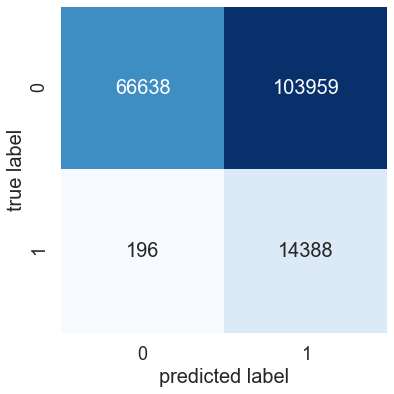

--------------------------------------------------
2000


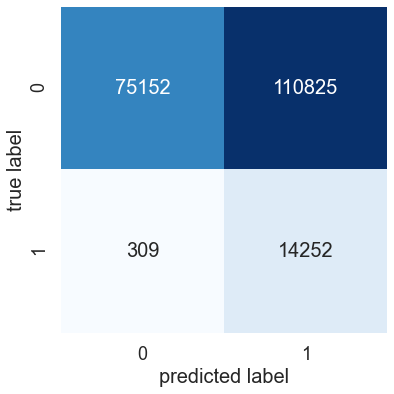

--------------------------------------------------
2001


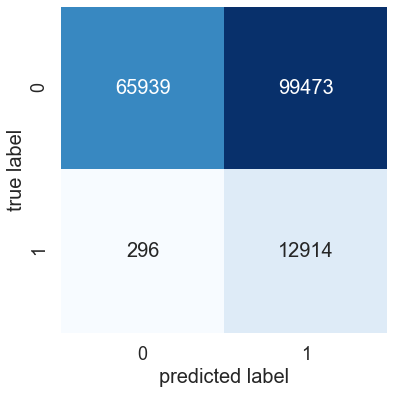

--------------------------------------------------
2002


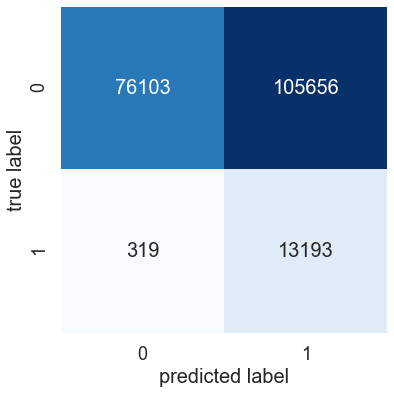

--------------------------------------------------
2003


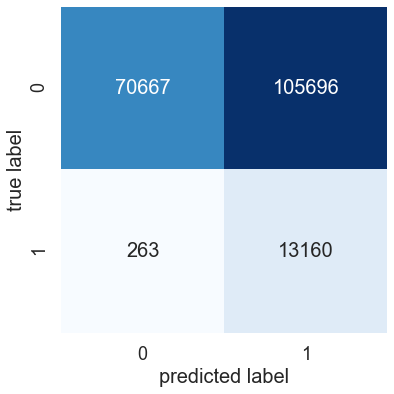

--------------------------------------------------
2004


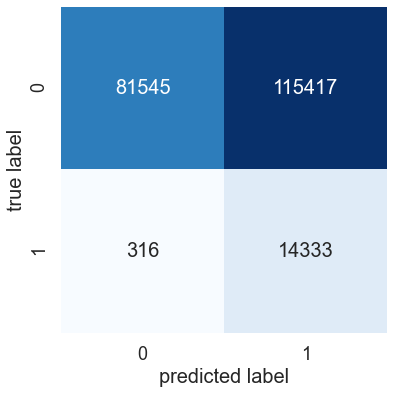

--------------------------------------------------
2005


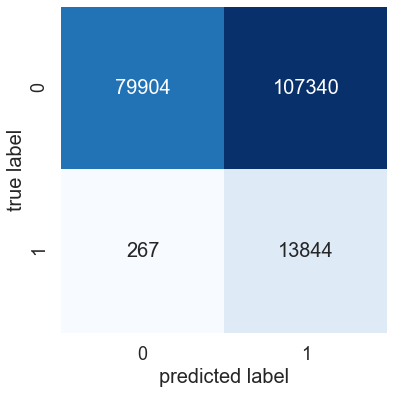

--------------------------------------------------
2006


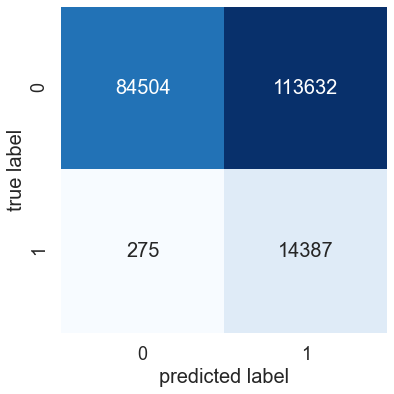

--------------------------------------------------
2007


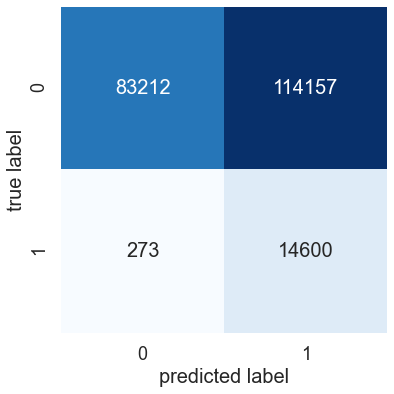

--------------------------------------------------
2008


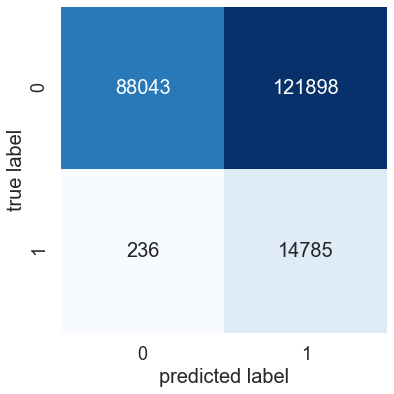

--------------------------------------------------
2009


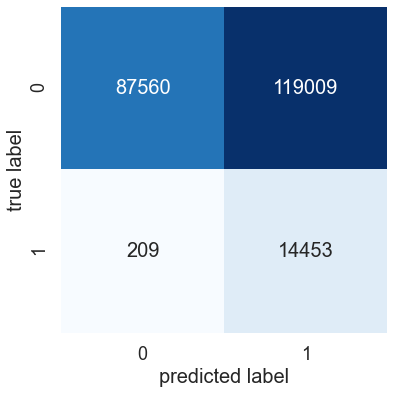

--------------------------------------------------
2010


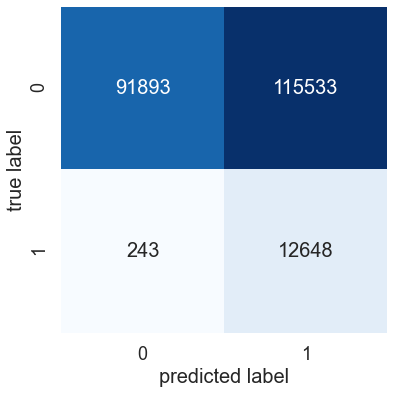

--------------------------------------------------
2011


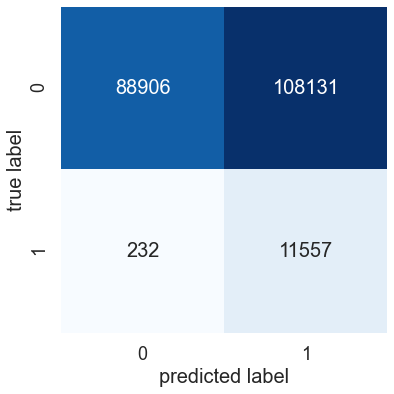

--------------------------------------------------
2012


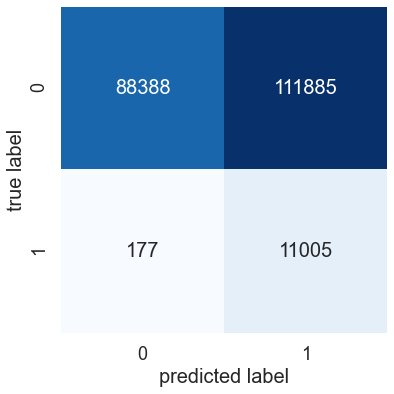

--------------------------------------------------
2013


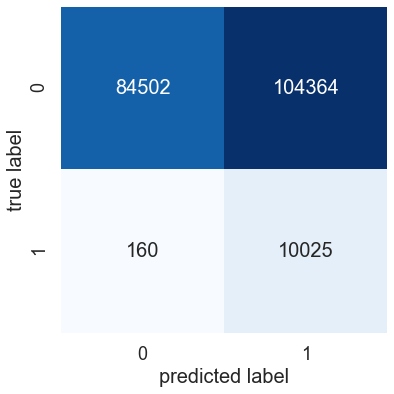

--------------------------------------------------
2014


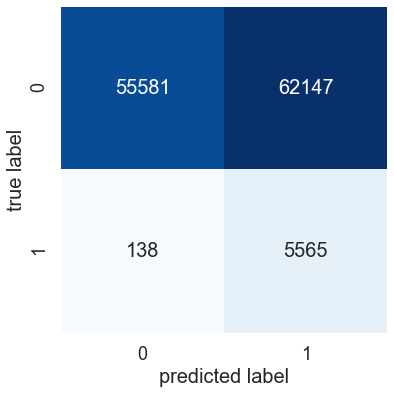

--------------------------------------------------
2015


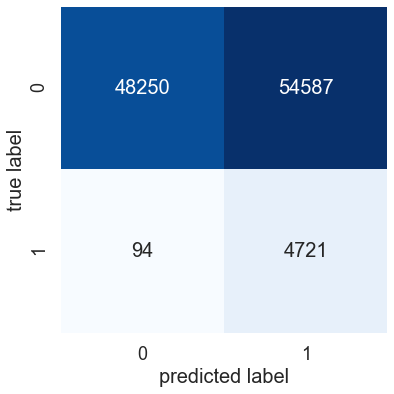

--------------------------------------------------
2016


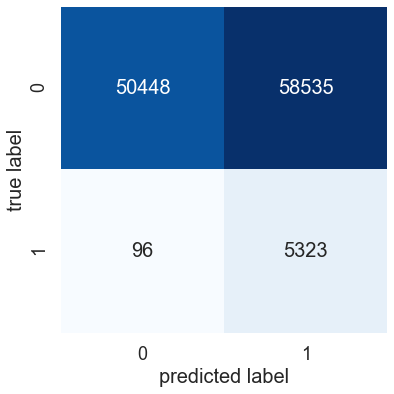

--------------------------------------------------
2017


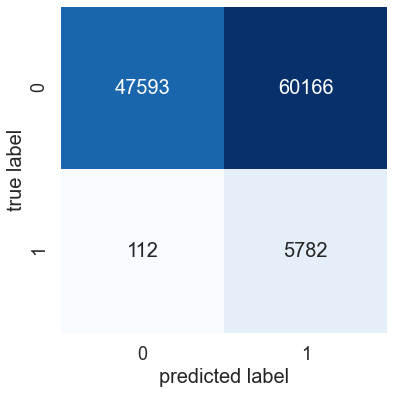

--------------------------------------------------
2018


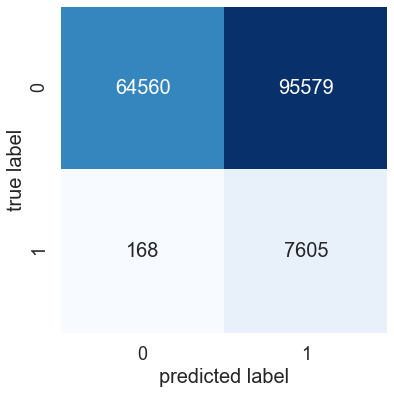

--------------------------------------------------
2019


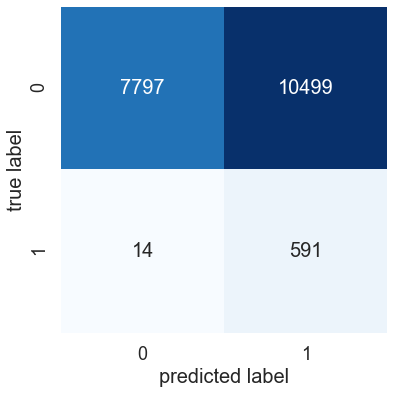

In [ ]:
for year, mat in mat_dict_21.items():
    print('-'*50)
    print(year)

    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

## Case 2，t=0.5

In [ ]:
model_dict = {k:v.copy() for k,v in df_dict.items()}

In [ ]:
year = 1999
depth = 2
threshold = 0.5
skip_limit = 1

skip_times = np.zeros([len(Names), 1])
mat_dict_22 = {}
num_data_22 = pd.DataFrame(columns=['Training', 'Training Deficient', 'Testing', 'Testing Deficient'])
result_22 = pd.DataFrame(columns=['recall', 'error', 'err_ratio', 'inspection_saved', 'inspection_saved_ratio','deficient_bridges', 'total_bridges'])

#delta_Num = ['ADT_029', 'YEAR_ADT_030', 'MAX_SPAN_LEN_MT_048', 'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060',
#             'CHANNEL_COND_061', 'OPERATING_RATING_064', 'STRUCTURAL_EVAL_067', 'DECK_GEOMETRY_EVAL_068',
#             'PERCENT_ADT_TRUCK_109']

Pretty_Print(delta_Num, 'Time-changing Features',2,62)

--------------------------------------------------------------
                    Time-changing Features                    
--------------------------------------------------------------
 019  : DETOUR_KILOS               029  : ADT                      
 059  : SUPERSTRUCTURE_COND        060  : SUBSTRUCTURE_COND        
 061  : CHANNEL_COND               064  : OPERATING_RATING         
 066  : INVENTORY_RATING           067  : STRUCTURAL_EVAL          
 068  : DECK_GEOMETRY_EVAL         069  : UNDCLRENCE_EVAL          
 070  : POSTING_EVAL               071  : WATERWAY_EVAL            
 072  : APPR_ROAD_EVAL             109  : PERCENT_ADT_TRUCK        
 114  : FUTURE_ADT               


In [ ]:
for col, df in model_dict.items():
    df.loc[:, str(year):] = np.nan
    model_dict[col] = df

In [ ]:
while year <= end_year:
    print('-'*25)
    print(year)
  
    if year == end_year:
        ins = ins_yr.copy()
    else:
        ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]

    v = ins.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)
    total_bridges = ins.loc[ins[str(year)] == year].shape[0]

    if year == end_year:
        cond = df_dict['DECK_COND_058'].copy()
    else:
        cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year+1))]

    v = cond.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

    idx_train = ins.index[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                        (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)])]

    idx_test  = ins.index[(ins[str(year)] == year) & (ins.count(axis=1) > depth) & (cond[str(year-1)] <= cond[str(year-2)])]

    ignore_index = set(ins.index) - set(idx_train) - set(idx_test)

  #======Generating Data======

    X_train = pd.DataFrame()
    X_test  = pd.DataFrame()

    for col, df in model_dict.items():

        #Moving to the Right
        df = df.iloc[:,:df.columns.get_loc(str(year))]
        v = df.values
        a = (~np.isnan(v)).argsort(1, kind='mergesort')

        df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
        #-------------------

        df_train = df.loc[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                          (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)])]

        df_test  = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) & (cond[str(year-1)] <= cond[str(year-2)])]

        if col == 'DECK_COND_058':
            y_train = np.where(df_train.iloc[:,-1] <= 6, 1, 0)
            old_cond = df_test.iloc[:,-1]
        else:
            if col in delta_Num:
                X_train[col] = df_train.iloc[:,-3:-1].mean(axis = 1)
                X_train[col + '_std']  = df_train.iloc[:,-3:-1].std(axis = 1)
                X_train[col + '_diff_1'] = np.subtract(df_train.iloc[:,-2],df_train.iloc[:,-3])

                X_test[col] = df_test.iloc[:,-2:].mean(axis = 1)
                X_test[col + '_std']  = df_test.iloc[:,-2:].std(axis = 1)
                X_test[col + '_diff_1'] = np.subtract(df_test.iloc[:,-1],df_test.iloc[:,-2])
            else:
                X_train[col] = df_train.iloc[:,-2]
                X_test[col]  = df_test.iloc[:,-1]
      
    num_deficient = np.sum(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year), str(year)] <= 4)
    y_test = np.where(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) &
                                                 (cond[str(year-1)] <= cond[str(year-2)]), str(year)] <= 4, 1, 0)
    print("Training Set: ", X_train.shape, y_train.shape, "Deficient: ", np.sum(y_train))
    print("Testing  Set: ", X_test.shape,  y_test.shape,  "Deficient: ", np.sum(y_test))
    num_data_22.loc[year] = [len(y_train), np.sum(y_train), len(y_test), np.sum(y_test)]


    #==========Undersampling==========

    rus = RandomUnderSampler(random_state=77)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    unique, counts = np.unique(y_train_res, return_counts=True)
    print(dict(zip(unique, counts)))
    
    X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
    X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

    X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
    X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

    chch1 = set(X_train_res.columns.values)
    chch2 = set(X_test_res.columns.values)
    
    mutual = chch1.intersection(chch2)
    
    X_train_res = X_train_res[mutual]
    X_test_res  = X_test_res[mutual]

    print(X_train_res.shape, X_test_res.shape)

    #======Train/Predict======
    model_RF = RandomForestClassifier(n_estimators = 500, random_state = 77, class_weight='balanced')
    model_RF.fit(X_train_res, y_train_res)
    y_scores = model_RF.predict_proba(X_test_res)[:,1]
    y_pred = np.array([1 if score >= threshold else 0 for score in y_scores])
    mat_dict_22[year] = confusion_matrix(y_test, y_pred)
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

    #======skip and redo======
    skip_index = []
    redo_index = []
    error = 0

    for jj, item in enumerate(y_pred):
        ii = X_test.index.values[jj]

        if (item == 0) & (skip_times[ii] < skip_limit):
            skip_index.append(ii)
            skip_times[ii] += 1

            if (item == 0) & (y_test[jj] == 1):
                error += 1

        else:
            redo_index.append(ii)
            skip_times[ii] = 0

    #======record======
    err_ratio = error/num_deficient
    inspection_saved = len(skip_index)
    ins_saved_ratio = len(skip_index)/total_bridges

    print("Error: %d, Error rate: %.6f, Ins_saved: %d, Ratio = %.4f" % (error, err_ratio, inspection_saved, ins_saved_ratio))
    result_22.loc[year] = [recall_score(y_test, y_pred), error, err_ratio, inspection_saved, ins_saved_ratio, num_deficient, total_bridges]

    #======Update======

    for col, df in model_dict.items():
    
        df.iloc[redo_index, df.columns.get_loc(str(year))]   = df_dict[col].iloc[redo_index, df.columns.get_loc(str(year))]
        df.iloc[list(ignore_index), df.columns.get_loc(str(year))] = df_dict[col].iloc[list(ignore_index), df.columns.get_loc(str(year))]

        if col == 'DECK_COND_058':
            df.iloc[skip_index, df.columns.get_loc(str(year))] = old_cond.loc[old_cond.index.isin(skip_index)]
        else:
            df.iloc[skip_index, df.columns.get_loc(str(year))] = X_test.loc[X_test.index.isin(skip_index), col]

        model_dict[col] = df

    year += 1

-------------------------
1999
Training Set:  (186648, 104) (186648,) Deficient:  86283
Testing  Set:  (185181, 104) (185181,) Deficient:  14584
{0: 86283, 1: 86283}
(172566, 438) (185181, 438)
Precision = 0.1536, Recall = 0.9541, f1 = 0.2645
Error: 670, Error rate: 0.045941, Ins_saved: 94571, Ratio = 0.4149
-------------------------
2000
Training Set:  (189868, 104) (189868,) Deficient:  85353
Testing  Set:  (200538, 104) (200538,) Deficient:  14561
{0: 85353, 1: 85353}
(170706, 437) (200538, 437)
Precision = 0.1437, Recall = 0.9396, f1 = 0.2492
Error: 717, Error rate: 0.049241, Ins_saved: 87962, Ratio = 0.3637
-------------------------
2001
Training Set:  (224526, 104) (224526,) Deficient:  101612
Testing  Set:  (178622, 104) (178622,) Deficient:  13210
{0: 101612, 1: 101612}
(203224, 439) (178622, 439)
Precision = 0.1467, Recall = 0.9314, f1 = 0.2535
Error: 333, Error rate: 0.025208, Ins_saved: 28125, Ratio = 0.1250
-------------------------
2002
Training Set:  (221302, 104) (221302

In [ ]:
# result_22.to_csv('D:\\ShaoTing\\result\\For_Paper\\result_205.csv', index = False)
result_22

,recall,error,err_ratio,inspection_saved,inspection_saved_ratio,deficient_bridges,total_bridges
1999,0.954059,670.0,0.045941,94571.0,0.414891,14584.0,227942.0
2000,0.939565,717.0,0.049241,87962.0,0.363666,14561.0,241876.0
2001,0.931416,333.0,0.025208,28125.0,0.124951,13210.0,225088.0
2002,0.928508,331.0,0.024497,32674.0,0.137604,13512.0,237449.0
2003,0.934888,537.0,0.040006,71567.0,0.317504,13423.0,225405.0
2004,0.928323,682.0,0.046556,81011.0,0.334740,14649.0,242012.0
2005,0.933740,419.0,0.029693,42840.0,0.182809,14111.0,234343.0
2006,0.925522,469.0,0.031987,45589.0,0.188909,14662.0,241328.0
2007,0.932697,579.0,0.038930,71674.0,0.296659,14873.0,241604.0
2008,0.936089,524.0,0.034884,76167.0,0.299279,15021.0,254502.0


In [ ]:
num_data_22

,Training,Training Deficient,Testing,Testing Deficient
1999,186648,86283,185181,14584
2000,189868,85353,200538,14561
2001,224526,101612,178622,13210
2002,221302,103882,195271,13512
2003,242723,113987,189786,13423
2004,240529,112955,211611,14649
2005,266062,124573,201355,14111
2006,266141,126063,212798,14662
2007,275950,131143,212242,14873
2008,273603,130347,224962,15021


In [ ]:
print(np.mean(result_22.err_ratio)*100)
print(np.mean(result_22.inspection_saved_ratio)*100)

3.909539034323501
24.899404368866477


--------------------------------------------------
1999


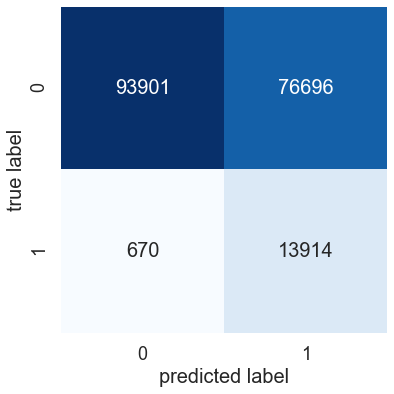

--------------------------------------------------
2000


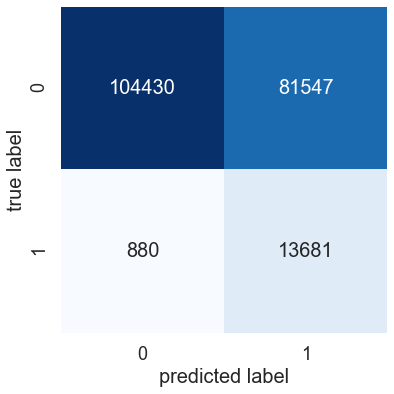

--------------------------------------------------
2001


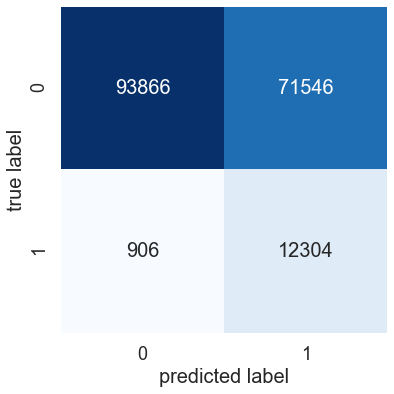

--------------------------------------------------
2002


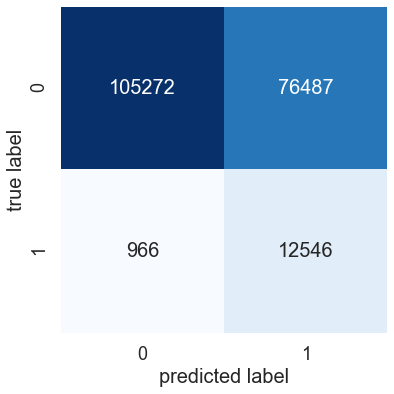

--------------------------------------------------
2003


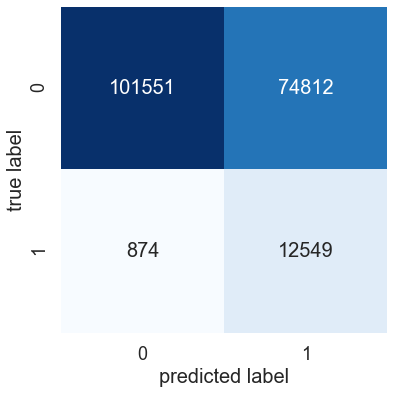

--------------------------------------------------
2004


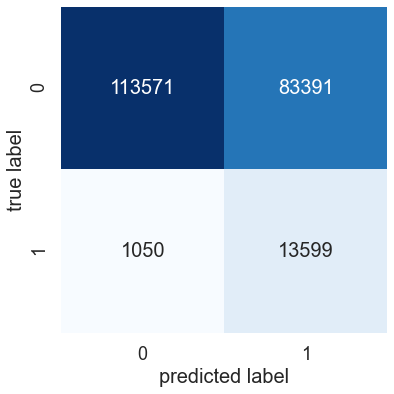

--------------------------------------------------
2005


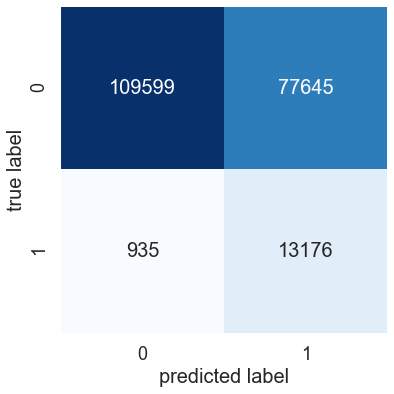

--------------------------------------------------
2006


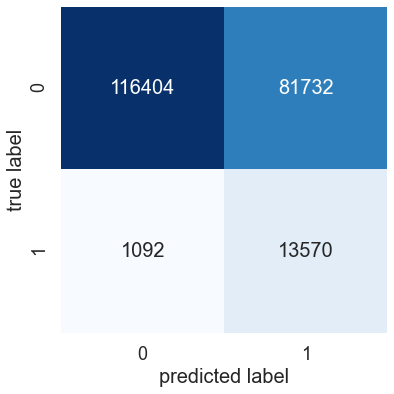

--------------------------------------------------
2007


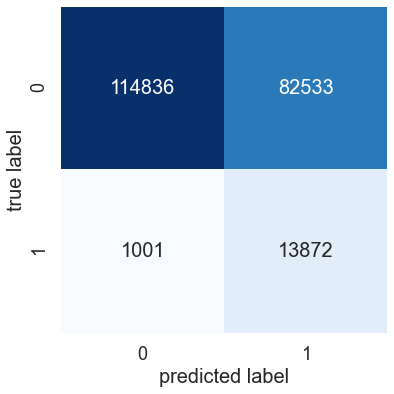

--------------------------------------------------
2008


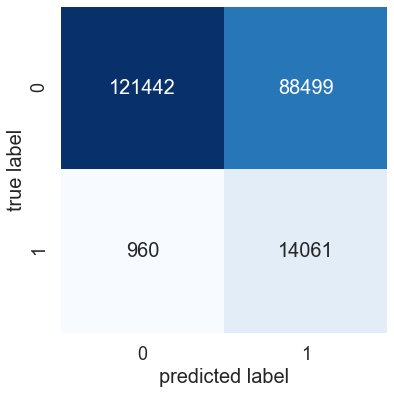

--------------------------------------------------
2009


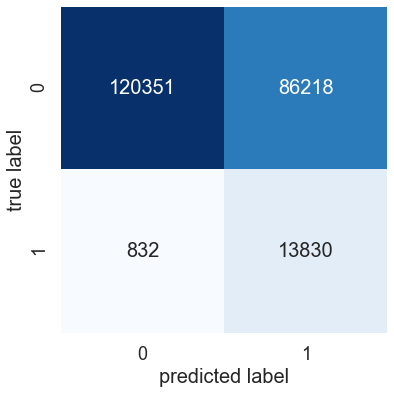

--------------------------------------------------
2010


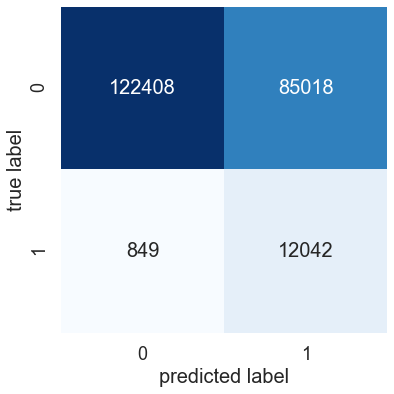

--------------------------------------------------
2011


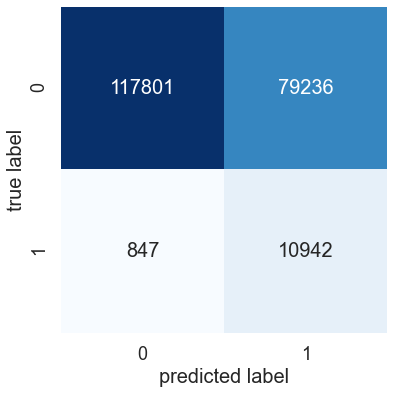

--------------------------------------------------
2012


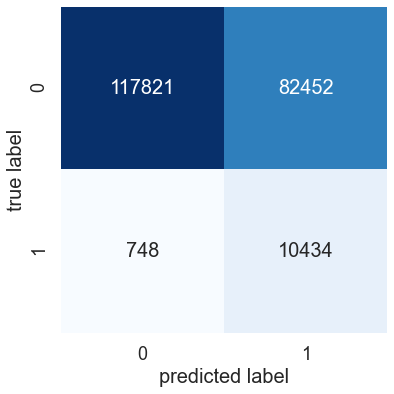

--------------------------------------------------
2013


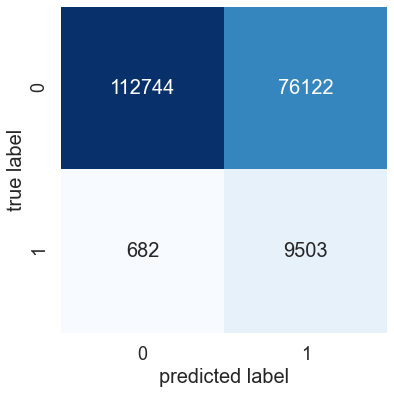

--------------------------------------------------
2014


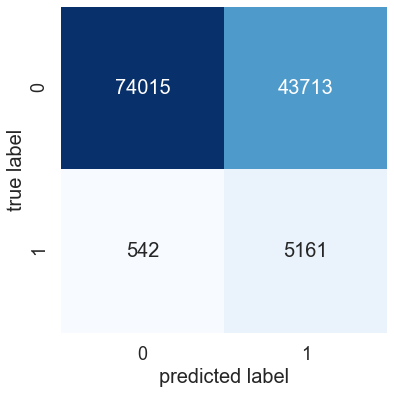

--------------------------------------------------
2015


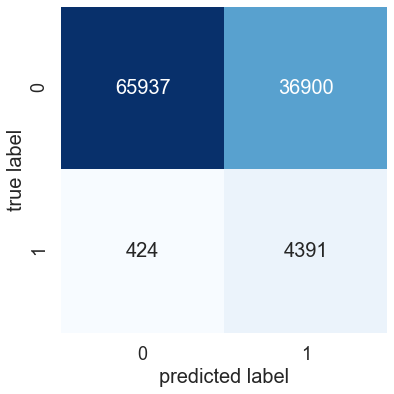

--------------------------------------------------
2016


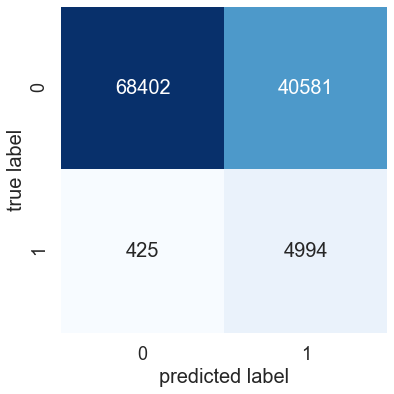

--------------------------------------------------
2017


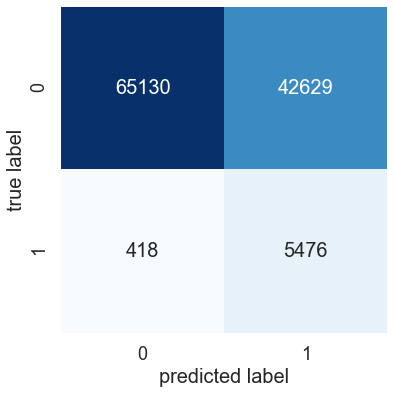

--------------------------------------------------
2018


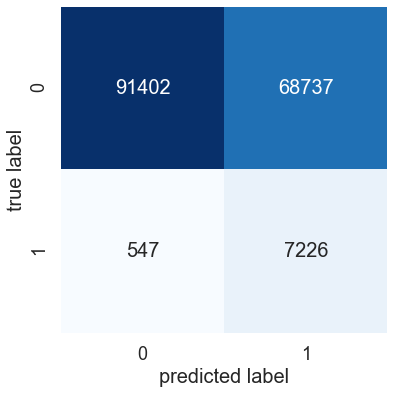

--------------------------------------------------
2019


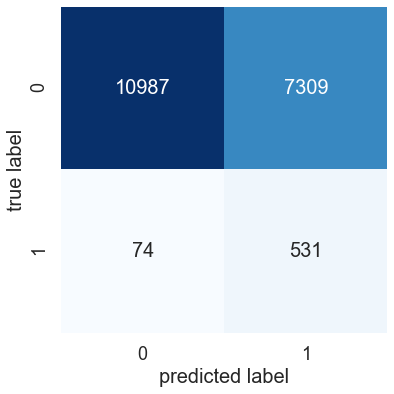

In [ ]:
for year, mat in mat_dict_22.items():
    print('-'*50)
    print(year)

    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

## Case 3，t=0.35

In [ ]:
model_dict = {k:v.copy() for k,v in df_dict.items()}

In [ ]:
year = 1999
depth = 3
threshold = 0.35
skip_limit = 1

skip_times = np.zeros([len(Names), 1])
mat_dict_31 = {}
num_data_31 = pd.DataFrame(columns=['Training', 'Training Deficient', 'Testing', 'Testing Deficient'])
result_31 = pd.DataFrame(columns=['recall', 'error', 'err_ratio', 'inspection_saved', 'inspection_saved_ratio','deficient_bridges', 'total_bridges'])

# delta_Num = ['ADT_029', 'YEAR_ADT_030', 'MAX_SPAN_LEN_MT_048', 'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060',
#              'CHANNEL_COND_061', 'OPERATING_RATING_064', 'STRUCTURAL_EVAL_067', 'DECK_GEOMETRY_EVAL_068',
#              'PERCENT_ADT_TRUCK_109']

Pretty_Print(delta_Num, 'Time-changing Features',2,62)

--------------------------------------------------------------
                    Time-changing Features                    
--------------------------------------------------------------
 019  : DETOUR_KILOS               029  : ADT                      
 059  : SUPERSTRUCTURE_COND        060  : SUBSTRUCTURE_COND        
 061  : CHANNEL_COND               064  : OPERATING_RATING         
 066  : INVENTORY_RATING           067  : STRUCTURAL_EVAL          
 068  : DECK_GEOMETRY_EVAL         069  : UNDCLRENCE_EVAL          
 070  : POSTING_EVAL               071  : WATERWAY_EVAL            
 072  : APPR_ROAD_EVAL             109  : PERCENT_ADT_TRUCK        
 114  : FUTURE_ADT               


In [ ]:
for col, df in model_dict.items():
    df.loc[:, str(year):] = np.nan
    model_dict[col] = df

In [ ]:
while year <= end_year:
    print('-'*25)
    print(year)
  
    if year == end_year:
        ins = ins_yr.copy()
    else:
        ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]
        
    v = ins.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)
    total_bridges = ins.loc[ins[str(year)] == year].shape[0]

    if year == end_year:
        cond = df_dict['DECK_COND_058'].copy()
    else:
        cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year+1))]

    v = cond.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

    idx_train = ins.index[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                        (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

    idx_test  = ins.index[(ins[str(year)] == year) & (ins.count(axis=1) > depth) &
                        (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

    ignore_index = set(ins.index) - set(idx_train) - set(idx_test)

    #======Generating Data======

    X_train = pd.DataFrame()
    X_test  = pd.DataFrame()

    for col, df in model_dict.items():

        #Moving to the Right
        df = df.iloc[:,:df.columns.get_loc(str(year))]
        v = df.values
        a = (~np.isnan(v)).argsort(1, kind='mergesort')

        df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
        #-------------------

        df_train = df.loc[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                          (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

        df_test  = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) & (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

        if col == 'DECK_COND_058':
            y_train = np.where(df_train.iloc[:,-1] <= 6, 1, 0)
            old_cond = df_test.iloc[:,-1]
        else:
            if col in delta_Num:
                X_train[col] = df_train.iloc[:,-4:-1].mean(axis = 1)
                X_train[col + '_std']  = df_train.iloc[:,-4:-1].std(axis = 1)
                X_train[col + '_diff_1'] = np.subtract(df_train.iloc[:,-2],df_train.iloc[:,-3])
                X_train[col + '_diff_2'] = np.subtract(df_train.iloc[:,-3],df_train.iloc[:,-4])

                X_test[col] = df_test.iloc[:,-3:].mean(axis = 1)
                X_test[col + '_std']  = df_test.iloc[:,-3:].std(axis = 1)
                X_test[col + '_diff_1'] = np.subtract(df_test.iloc[:,-1],df_test.iloc[:,-2])
                X_test[col + '_diff_2'] = np.subtract(df_test.iloc[:,-2],df_test.iloc[:,-3])
            else:
                X_train[col] = df_train.iloc[:,-2]
                X_test[col]  = df_test.iloc[:,-1]
      
    num_deficient = np.sum(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year), str(year)] <= 4)
    y_test = np.where(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) &
                                                 (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)]), str(year)] <= 4, 1, 0)
    print("Training Set: ", X_train.shape, y_train.shape, "Deficient: ", np.sum(y_train))
    print("Testing  Set: ", X_test.shape,  y_test.shape,  "Deficient: ", np.sum(y_test))
    num_data_31.loc[year] = [len(y_train), np.sum(y_train), len(y_test), np.sum(y_test)]


    #==========RandomUnderSampler==========

    rus = RandomUnderSampler(random_state=77)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    unique, counts = np.unique(y_train_res, return_counts=True)
    print(dict(zip(unique, counts)))
    
    X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
    X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

    X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
    X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

    chch1 = set(X_train_res.columns.values)
    chch2 = set(X_test_res.columns.values)
    
    mutual = chch1.intersection(chch2)
    
    X_train_res = X_train_res[mutual]
    X_test_res  = X_test_res[mutual]

    print(X_train_res.shape, X_test_res.shape)

    #======Train/Predict======
    model_RF = RandomForestClassifier(n_estimators = 100, random_state = 77, class_weight='balanced')
    model_RF.fit(X_train_res, y_train_res)
    y_scores = model_RF.predict_proba(X_test_res)[:,1]
    y_pred = np.array([1 if score >= threshold else 0 for score in y_scores])
    mat_dict_31[year] = confusion_matrix(y_test, y_pred)
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

    #======skip and redo======
    skip_index = []
    redo_index = []
    error  = 0

    for jj, item in enumerate(y_pred):
        ii = X_test.index.values[jj]
    
        if (item == 0) & (skip_times[ii] < skip_limit):
            skip_index.append(ii)
            skip_times[ii] += 1
            
            if (item == 0) & (y_test[jj] == 1):
                error += 1
            
        else:
            redo_index.append(ii)
            skip_times[ii] = 0


    #======record======
    err_ratio = error/num_deficient
    inspection_saved = len(skip_index)
    ins_saved_ratio = len(skip_index)/total_bridges

    print("Error rate: %.6f, Ins_saved: %d, Ratio = %.4f" % (err_ratio, inspection_saved, ins_saved_ratio))
    result_31.loc[year] = [recall_score(y_test, y_pred), error, err_ratio, inspection_saved, ins_saved_ratio, num_deficient, total_bridges]

    #======Update======

    for col, df in model_dict.items():
    
        df.iloc[redo_index, df.columns.get_loc(str(year))]   = df_dict[col].iloc[redo_index, df.columns.get_loc(str(year))]
        df.iloc[list(ignore_index), df.columns.get_loc(str(year))] = df_dict[col].iloc[list(ignore_index), df.columns.get_loc(str(year))]

        if col == 'DECK_COND_058':
            df.iloc[skip_index, df.columns.get_loc(str(year))] = old_cond.loc[old_cond.index.isin(skip_index)]
        else:
            df.iloc[skip_index, df.columns.get_loc(str(year))] = X_test.loc[X_test.index.isin(skip_index), col]

        model_dict[col] = df

    year += 1

-------------------------
1999
Training Set:  (117938, 119) (117938,) Deficient:  55932
Testing  Set:  (150120, 119) (150120,) Deficient:  12403
{0: 55932, 1: 55932}
(111864, 439) (150120, 439)
Precision = 0.1234, Recall = 0.9899, f1 = 0.2195
Error rate: 0.010078, Ins_saved: 50652, Ratio = 0.2222
-------------------------
2000
Training Set:  (130590, 119) (130590,) Deficient:  62261
Testing  Set:  (169221, 119) (169221,) Deficient:  12944
{0: 62261, 1: 62261}
(124522, 443) (169221, 443)
Precision = 0.1157, Recall = 0.9833, f1 = 0.2070
Error rate: 0.014988, Ins_saved: 50275, Ratio = 0.2079
-------------------------
2001
Training Set:  (167594, 119) (167594,) Deficient:  80101
Testing  Set:  (154506, 119) (154506,) Deficient:  11913
{0: 80101, 1: 80101}
(160202, 448) (154506, 448)
Precision = 0.1182, Recall = 0.9811, f1 = 0.2109
Error rate: 0.007555, Ins_saved: 20807, Ratio = 0.0924
-------------------------
2002
Training Set:  (170128, 119) (170128,) Deficient:  81384
Testing  Set:  (17

In [ ]:
result_31.to_csv('D:\\ShaoTing\\result\\For_Paper\\result_3035.csv', index = False)
result_31

,recall,error,err_ratio,inspection_saved,inspection_saved_ratio,deficient_bridges,total_bridges
1999,0.989922,125.0,0.010078,50652.0,0.222214,12403.0,227942.0
2000,0.983313,194.0,0.014988,50275.0,0.207854,12944.0,241876.0
2001,0.981113,90.0,0.007555,20807.0,0.092439,11913.0,225088.0
2002,0.976945,103.0,0.008245,24632.0,0.103736,12492.0,237449.0
2003,0.981099,137.0,0.011509,41317.0,0.183301,11904.0,225405.0
2004,0.977911,201.0,0.015310,49568.0,0.204816,13129.0,242012.0
2005,0.981530,119.0,0.009083,30213.0,0.128926,13102.0,234343.0
2006,0.981983,116.0,0.008394,32395.0,0.134236,13820.0,241328.0
2007,0.983065,130.0,0.009211,45839.0,0.189728,14113.0,241604.0
2008,0.984860,118.0,0.008271,49301.0,0.193716,14267.0,254502.0


In [ ]:
num_data_31

,Training,Training Deficient,Testing,Testing Deficient
1999,117938,55932,150120,12403
2000,130590,62261,169221,12944
2001,167594,80101,154506,11913
2002,170128,81384,171249,12492
2003,191532,91735,163331,11904
2004,187941,90853,182823,13129
2005,210045,101084,175945,13102
2006,212046,103193,192222,13820
2007,226420,110399,193965,14113
2008,228918,111821,206095,14267


In [ ]:
print(np.mean(result_31.err_ratio)*100)
print(np.mean(result_31.inspection_saved_ratio)*100)

0.9749214307009053
15.308673703011392


--------------------------------------------------
1999


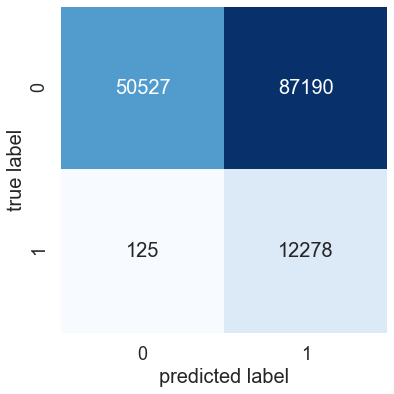

--------------------------------------------------
2000


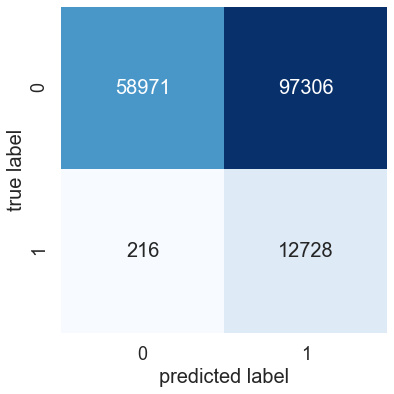

--------------------------------------------------
2001


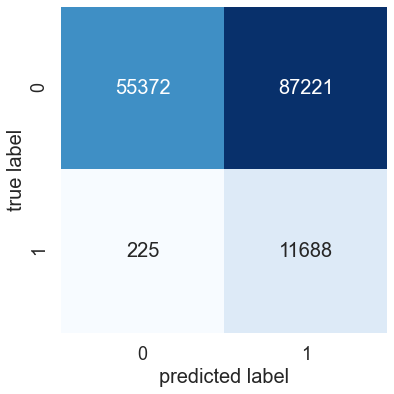

--------------------------------------------------
2002


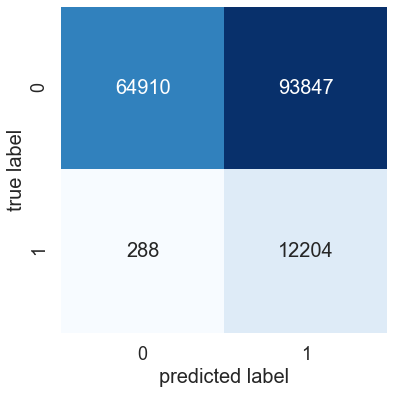

--------------------------------------------------
2003


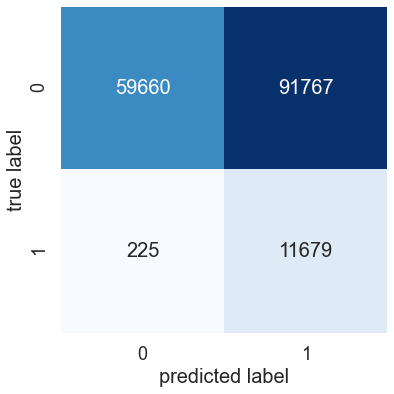

--------------------------------------------------
2004


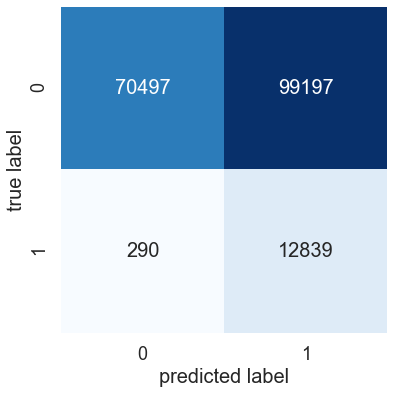

--------------------------------------------------
2005


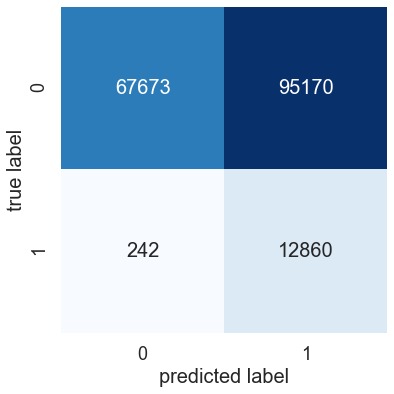

--------------------------------------------------
2006


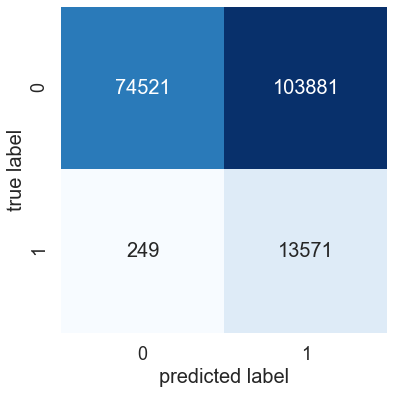

--------------------------------------------------
2007


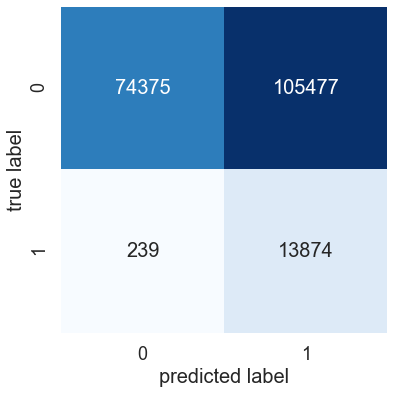

--------------------------------------------------
2008


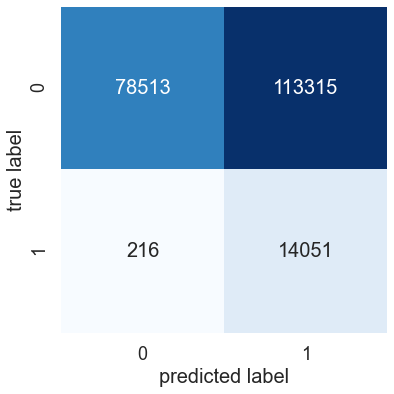

--------------------------------------------------
2009


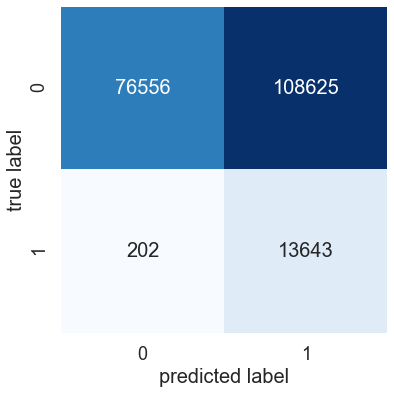

--------------------------------------------------
2010


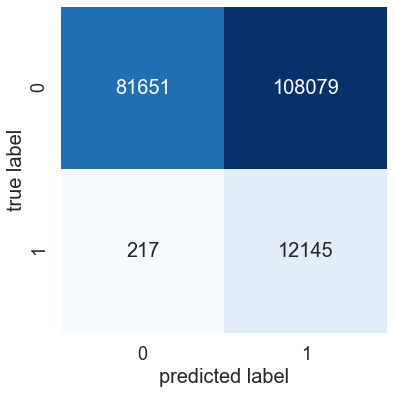

--------------------------------------------------
2011


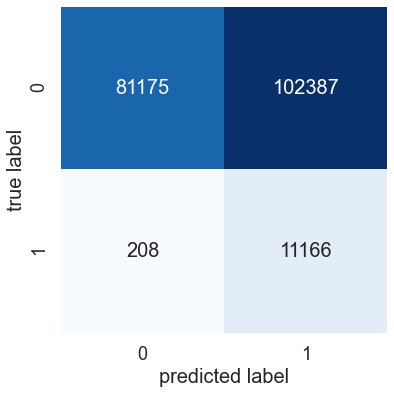

--------------------------------------------------
2012


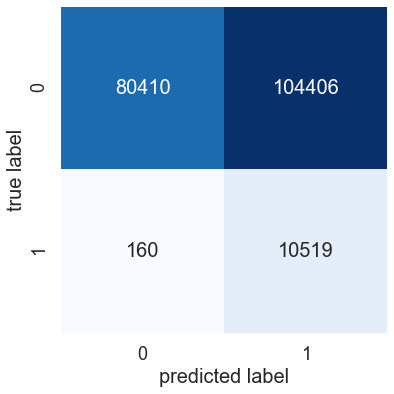

--------------------------------------------------
2013


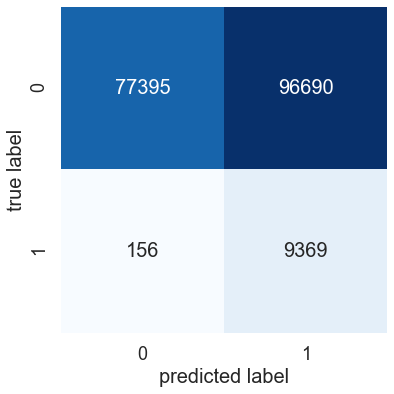

--------------------------------------------------
2014


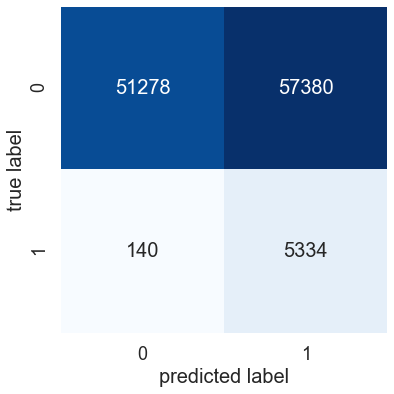

--------------------------------------------------
2015


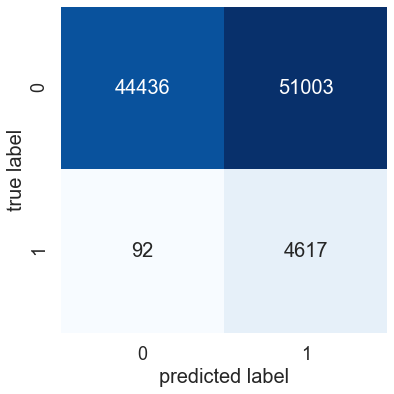

--------------------------------------------------
2016


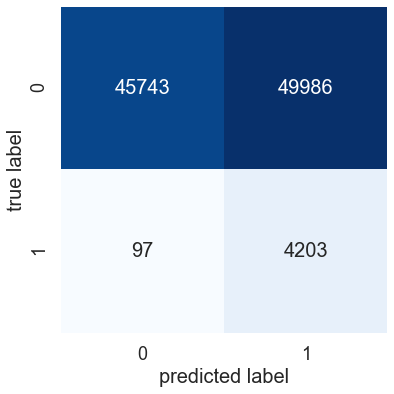

--------------------------------------------------
2017


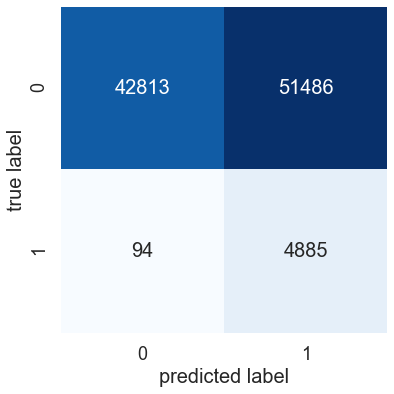

--------------------------------------------------
2018


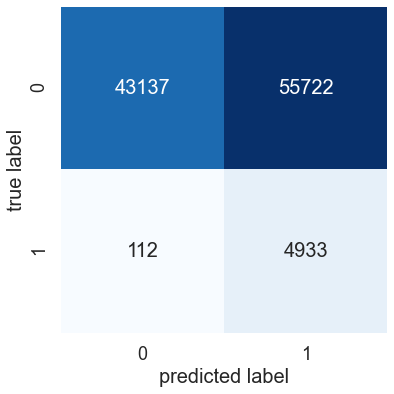

--------------------------------------------------
2019


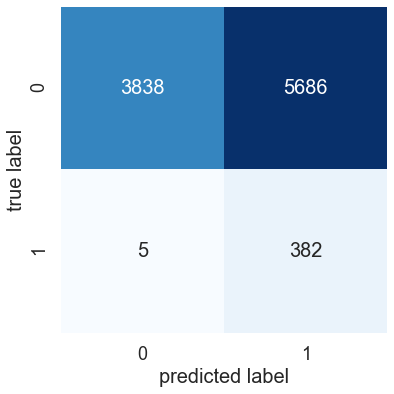

In [ ]:
for year, mat in mat_dict_31.items():
    print('-'*50)
    print(year)

    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

## Case 3，t=0.5

In [ ]:
model_dict = {k:v.copy() for k,v in df_dict.items()}

In [ ]:
year = 1999
depth = 3
threshold = 0.5
skip_limit = 1

skip_times = np.zeros([len(Names), 1])
mat_dict_32 = {}
num_data_32 = pd.DataFrame(columns=['Training', 'Training Deficient', 'Testing', 'Testing Deficient'])
result_32 = pd.DataFrame(columns=['recall', 'error', 'err_ratio', 'inspection_saved', 'inspection_saved_ratio','deficient_bridges', 'total_bridges'])

# delta_Num = ['ADT_029', 'YEAR_ADT_030', 'MAX_SPAN_LEN_MT_048', 'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060',
#              'CHANNEL_COND_061', 'OPERATING_RATING_064', 'STRUCTURAL_EVAL_067', 'DECK_GEOMETRY_EVAL_068',
#              'PERCENT_ADT_TRUCK_109']

Pretty_Print(delta_Num, 'Time-changing Features',2,62)

--------------------------------------------------------------
                    Time-changing Features                    
--------------------------------------------------------------
 019  : DETOUR_KILOS               029  : ADT                      
 059  : SUPERSTRUCTURE_COND        060  : SUBSTRUCTURE_COND        
 061  : CHANNEL_COND               064  : OPERATING_RATING         
 066  : INVENTORY_RATING           067  : STRUCTURAL_EVAL          
 068  : DECK_GEOMETRY_EVAL         069  : UNDCLRENCE_EVAL          
 070  : POSTING_EVAL               071  : WATERWAY_EVAL            
 072  : APPR_ROAD_EVAL             109  : PERCENT_ADT_TRUCK        
 114  : FUTURE_ADT               


In [ ]:
for col, df in model_dict.items():
    df.loc[:, str(year):] = np.nan
    model_dict[col] = df

In [ ]:
while year <= end_year:
    print('-'*25)
    print(year)
  
    if year == end_year:
        ins = ins_yr.copy()
    else:
        ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]
        
    v = ins.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)
    total_bridges = ins.loc[ins[str(year)] == year].shape[0]

    if year == end_year:
        cond = df_dict['DECK_COND_058'].copy()
    else:
        cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year+1))]

    v = cond.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')
    cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

    idx_train = ins.index[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                        (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

    idx_test  = ins.index[(ins[str(year)] == year) & (ins.count(axis=1) > depth) &
                        (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

    ignore_index = set(ins.index) - set(idx_train) - set(idx_test)

    #======Generating Data======

    X_train = pd.DataFrame()
    X_test  = pd.DataFrame()

    for col, df in model_dict.items():

        #Moving to the Right
        df = df.iloc[:,:df.columns.get_loc(str(year))]
        v = df.values
        a = (~np.isnan(v)).argsort(1, kind='mergesort')

        df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
        #-------------------

        df_train = df.loc[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                          (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

        df_test  = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) & (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

        if col == 'DECK_COND_058':
            y_train = np.where(df_train.iloc[:,-1] <= 6, 1, 0)
            old_cond = df_test.iloc[:,-1]
        else:
            if col in delta_Num:
                X_train[col] = df_train.iloc[:,-4:-1].mean(axis = 1)
                X_train[col + '_std']  = df_train.iloc[:,-4:-1].std(axis = 1)
                X_train[col + '_diff_1'] = np.subtract(df_train.iloc[:,-2],df_train.iloc[:,-3])
                X_train[col + '_diff_2'] = np.subtract(df_train.iloc[:,-3],df_train.iloc[:,-4])

                X_test[col] = df_test.iloc[:,-3:].mean(axis = 1)
                X_test[col + '_std']  = df_test.iloc[:,-3:].std(axis = 1)
                X_test[col + '_diff_1'] = np.subtract(df_test.iloc[:,-1],df_test.iloc[:,-2])
                X_test[col + '_diff_2'] = np.subtract(df_test.iloc[:,-2],df_test.iloc[:,-3])
            else:
                X_train[col] = df_train.iloc[:,-2]
                X_test[col]  = df_test.iloc[:,-1]
      
    num_deficient = np.sum(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year), str(year)] <= 4)
    y_test = np.where(df_dict['DECK_COND_058'].loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) &
                                                 (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)]), str(year)] <= 4, 1, 0)
    print("Training Set: ", X_train.shape, y_train.shape, "Deficient: ", np.sum(y_train))
    print("Testing  Set: ", X_test.shape,  y_test.shape,  "Deficient: ", np.sum(y_test))
    num_data_32.loc[year] = [len(y_train), np.sum(y_train), len(y_test), np.sum(y_test)]


    #==========RandomUnderSampler==========

    rus = RandomUnderSampler(random_state=77)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    unique, counts = np.unique(y_train_res, return_counts=True)
    print(dict(zip(unique, counts)))
    
    X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
    X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

    X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
    X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

    chch1 = set(X_train_res.columns.values)
    chch2 = set(X_test_res.columns.values)
    
    mutual = chch1.intersection(chch2)
    
    X_train_res = X_train_res[mutual]
    X_test_res  = X_test_res[mutual]

    print(X_train_res.shape, X_test_res.shape)

    #======Train/Predict======
    model_RF = RandomForestClassifier(n_estimators = 500, random_state = 77, class_weight='balanced')
    model_RF.fit(X_train_res, y_train_res)
    y_scores = model_RF.predict_proba(X_test_res)[:,1]
    y_pred = np.array([1 if score >= threshold else 0 for score in y_scores])
    mat_dict_32[year] = confusion_matrix(y_test, y_pred)
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

    #======skip and redo======
    skip_index = []
    redo_index = []
    error  = 0

    for jj, item in enumerate(y_pred):
        ii = X_test.index.values[jj]
    
        if (item == 0) & (skip_times[ii] < skip_limit):
            skip_index.append(ii)
            skip_times[ii] += 1
            
            if (item == 0) & (y_test[jj] == 1):
                error += 1
            
        else:
            redo_index.append(ii)
            skip_times[ii] = 0


    #======record======
    err_ratio = error/num_deficient
    inspection_saved = len(skip_index)
    ins_saved_ratio = len(skip_index)/total_bridges

    print("Error rate: %.6f, Ins_saved: %d, Ratio = %.4f" % (err_ratio, inspection_saved, ins_saved_ratio))
    result_32.loc[year] = [recall_score(y_test, y_pred), error, err_ratio, inspection_saved, ins_saved_ratio, num_deficient, total_bridges]

    #======Update======

    for col, df in model_dict.items():
    
        df.iloc[redo_index, df.columns.get_loc(str(year))]   = df_dict[col].iloc[redo_index, df.columns.get_loc(str(year))]
        df.iloc[list(ignore_index), df.columns.get_loc(str(year))] = df_dict[col].iloc[list(ignore_index), df.columns.get_loc(str(year))]

        if col == 'DECK_COND_058':
            df.iloc[skip_index, df.columns.get_loc(str(year))] = old_cond.loc[old_cond.index.isin(skip_index)]
        else:
            df.iloc[skip_index, df.columns.get_loc(str(year))] = X_test.loc[X_test.index.isin(skip_index), col]

        model_dict[col] = df

    year += 1

-------------------------
1999
Training Set:  (117938, 119) (117938,) Deficient:  55932
Testing  Set:  (150120, 119) (150120,) Deficient:  12403
{0: 55932, 1: 55932}
(111864, 439) (150120, 439)
Precision = 0.1554, Recall = 0.9597, f1 = 0.2675
Error rate: 0.040313, Ins_saved: 73523, Ratio = 0.3226
-------------------------
2000
Training Set:  (130590, 119) (130590,) Deficient:  60999
Testing  Set:  (169221, 119) (169221,) Deficient:  12944
{0: 60999, 1: 60999}
(121998, 444) (169221, 444)
Precision = 0.1465, Recall = 0.9425, f1 = 0.2535
Error rate: 0.047976, Ins_saved: 71546, Ratio = 0.2958
-------------------------
2001
Training Set:  (167594, 119) (167594,) Deficient:  78638
Testing  Set:  (154506, 119) (154506,) Deficient:  11913
{0: 78638, 1: 78638}
(157276, 448) (154506, 448)
Precision = 0.1521, Recall = 0.9378, f1 = 0.2617
Error rate: 0.023336, Ins_saved: 28467, Ratio = 0.1265
-------------------------
2002
Training Set:  (170128, 119) (170128,) Deficient:  80562
Testing  Set:  (17

In [ ]:
# result_32.to_csv('D:\\ShaoTing\\result\\For_Paper\\result_305.csv', index = False)
result_32

,recall,error,err_ratio,inspection_saved,inspection_saved_ratio,deficient_bridges,total_bridges
1999,0.959687,500.0,0.040313,73523.0,0.322551,12403.0,227942.0
2000,0.942522,621.0,0.047976,71546.0,0.295796,12944.0,241876.0
2001,0.937799,278.0,0.023336,28467.0,0.126471,11913.0,225088.0
2002,0.933557,298.0,0.023855,31219.0,0.131477,12492.0,237449.0
2003,0.938844,457.0,0.038390,59350.0,0.263304,11904.0,225405.0
2004,0.930078,608.0,0.046310,68198.0,0.281796,13129.0,242012.0
2005,0.935201,387.0,0.029537,38369.0,0.163730,13102.0,234343.0
2006,0.924023,451.0,0.032634,42223.0,0.174961,13820.0,241328.0
2007,0.933253,530.0,0.037554,64470.0,0.266842,14113.0,241604.0
2008,0.938600,504.0,0.035326,69079.0,0.271428,14267.0,254502.0


In [ ]:
num_data_32

,Training,Training Deficient,Testing,Testing Deficient
1999,117938,55932,150120,12403
2000,130590,60999,169221,12944
2001,167594,78638,154506,11913
2002,170128,80562,171249,12492
2003,191532,90997,163331,11904
2004,187941,89732,182823,13129
2005,210045,99728,175945,13102
2006,212046,102277,192222,13820
2007,226420,109476,193965,14113
2008,228918,110479,206095,14267


In [ ]:
print(np.mean(result_32.err_ratio)*100)
print(np.mean(result_32.inspection_saved_ratio)*100)

3.7841445799165965
20.705794644801337


--------------------------------------------------
1999


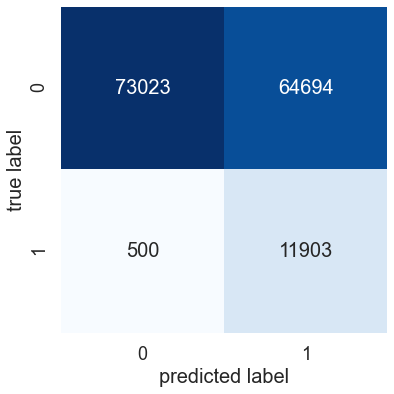

--------------------------------------------------
2000


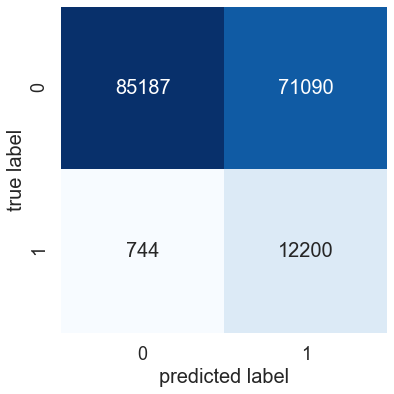

--------------------------------------------------
2001


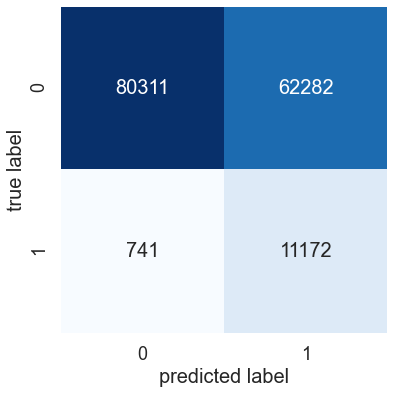

--------------------------------------------------
2002


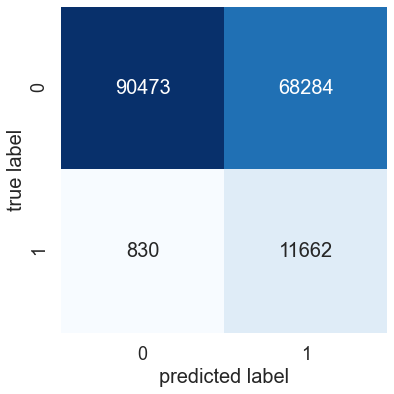

--------------------------------------------------
2003


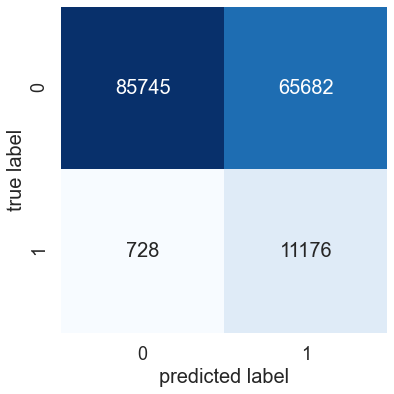

--------------------------------------------------
2004


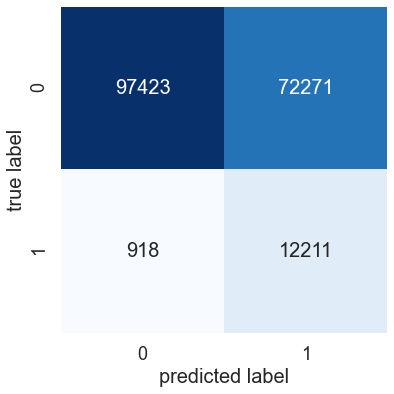

--------------------------------------------------
2005


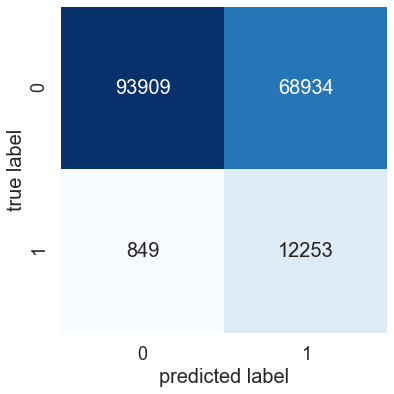

--------------------------------------------------
2006


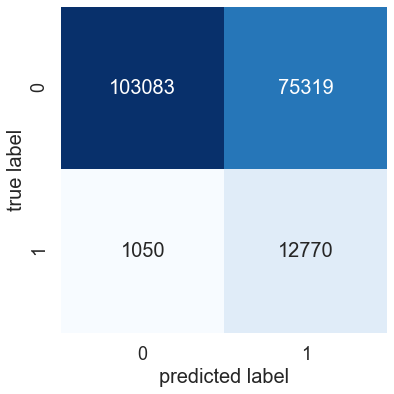

--------------------------------------------------
2007


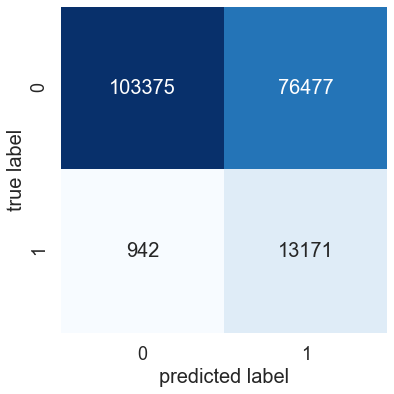

--------------------------------------------------
2008


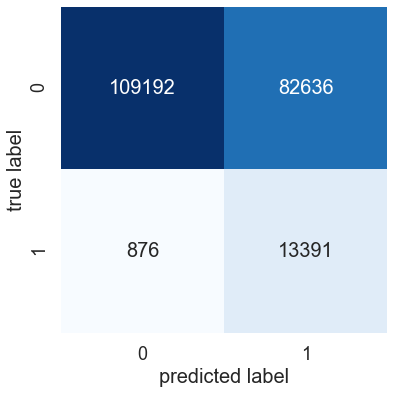

--------------------------------------------------
2009


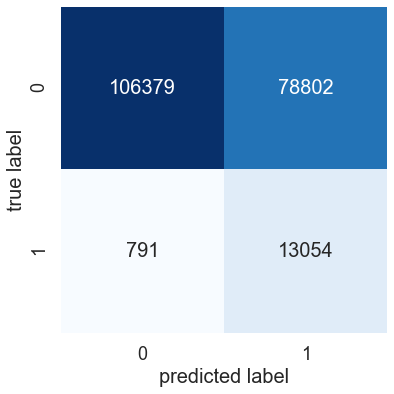

--------------------------------------------------
2010


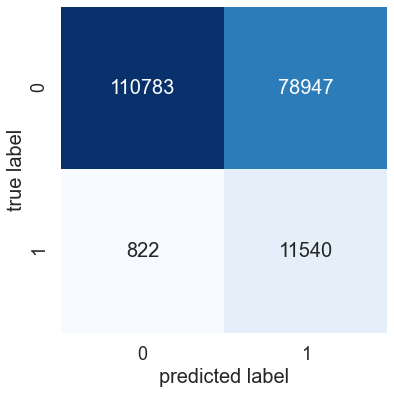

--------------------------------------------------
2011


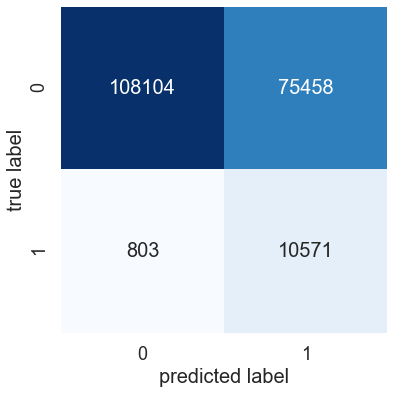

--------------------------------------------------
2012


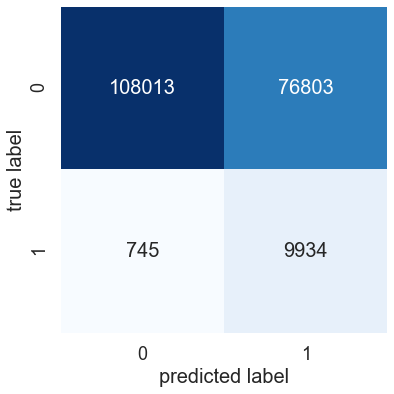

--------------------------------------------------
2013


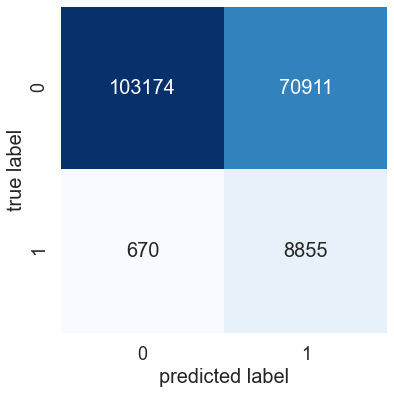

--------------------------------------------------
2014


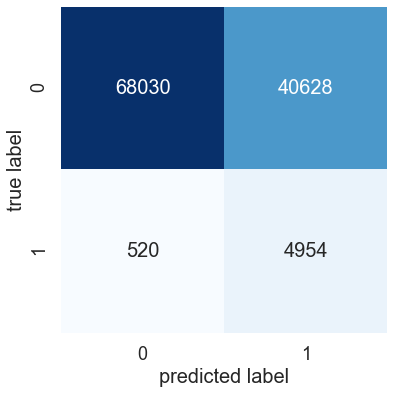

--------------------------------------------------
2015


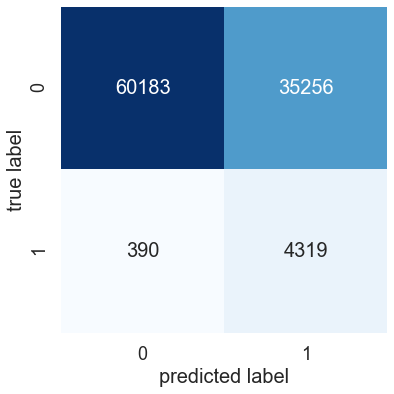

--------------------------------------------------
2016


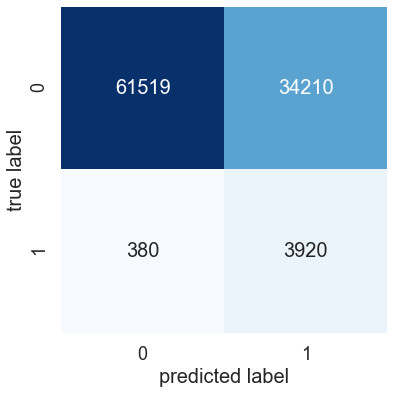

--------------------------------------------------
2017


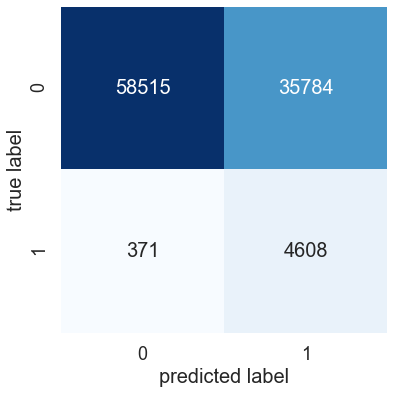

--------------------------------------------------
2018


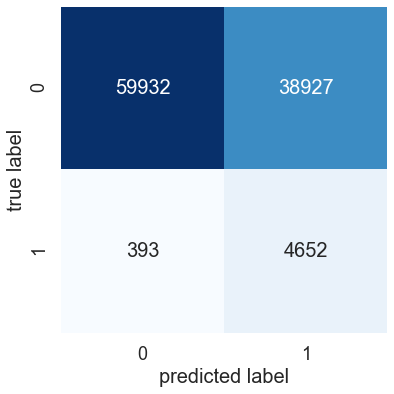

--------------------------------------------------
2019


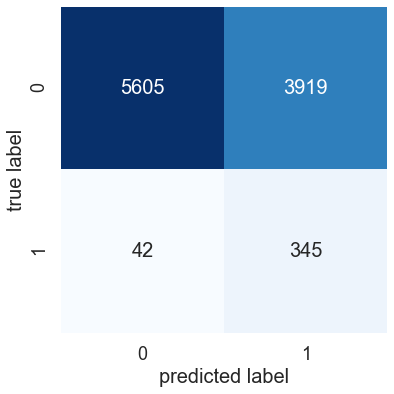

In [ ]:
for year, mat in mat_dict_32.items():
    print('-'*50)
    print(year)

    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

## 結果比較、作圖

In [ ]:
result_102  = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_11.csv')
result_1035 = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_1035.csv')
result_105  = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_105.csv')

result_202  = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_21.csv')
result_2035 = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_2035.csv')
result_205  = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_205.csv')

result_302  = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_31.csv')
result_3035 = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_3035.csv')
result_305  = pd.read_csv('D:\\ShaoTing\\result\\For_Paper\\result_305.csv')

case1 = [result_102, result_1035, result_105]
case2 = [result_202, result_2035, result_205]
case3 = [result_302, result_3035, result_305]
tt = [0.2, 0.35, 0.5]

In [ ]:
df_deck_number = df_deck_number.sort_values(by=['Unnamed: 0'])
number_of_deficient = df_deck_number.loc[df_deck_number['Unnamed: 0'] >= 1999, 'number_of_deficient'].to_numpy()

array([16643, 16151, 15720, 15625, 14897, 15629, 15204, 15574, 15888,
       15903, 15288, 14752, 13724, 12774, 11502, 10510,  9641,  9045,
        9195,  8831,   647], dtype=int64)

In [ ]:
for df1, df2, df3, t in zip(case1, case2, case3, tt):
    print('-'*100)
    print(t)
    
    print('Case 1')
    print(np.mean(df1.err_ratio)*100)
    print(np.mean(df1.inspection_saved_ratio)*100)
    
    print('Case 2')
    print(np.mean(df2.err_ratio)*100)
    print(np.mean(df2.inspection_saved_ratio)*100)
    
    print('Case 3')
    print(np.mean(df3.err_ratio)*100)
    print(np.mean(df3.inspection_saved_ratio)*100)

----------------------------------------------------------------------------------------------------
0.2
Case 1
0.1652033337786635
12.682387548590965
Case 2
0.11545045132425694
10.433642006682701
Case 3
0.1117451018783935
8.499896083291542
----------------------------------------------------------------------------------------------------
0.35
Case 1
1.1491552956823259
21.57934795556647
Case 2
0.9039447381937762
18.434561577459675
Case 3
0.7212581155795637
15.308673703011392
----------------------------------------------------------------------------------------------------
0.5
Case 1
3.4393098241209694
28.028785583319376
Case 2
3.2706132334972096
24.820932102278693
Case 3
2.788892172985093
20.685051008153415


### 三種Case比較

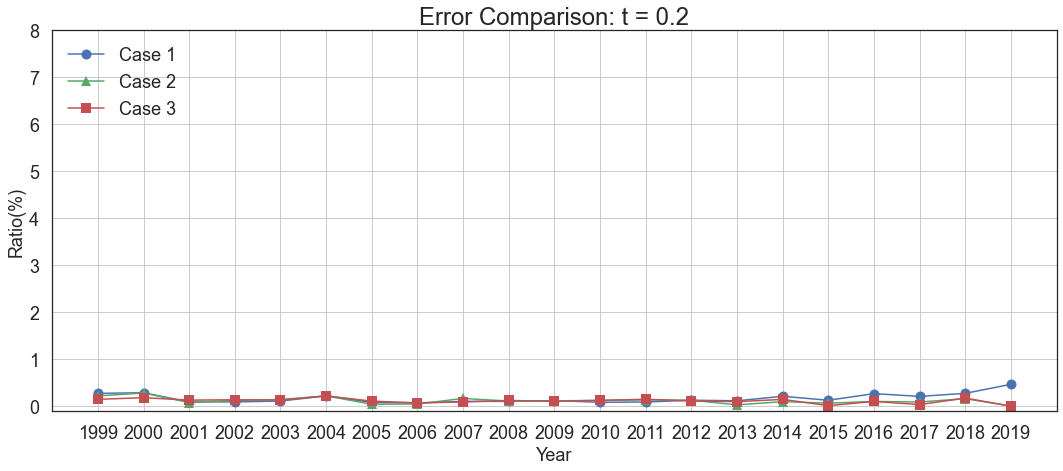

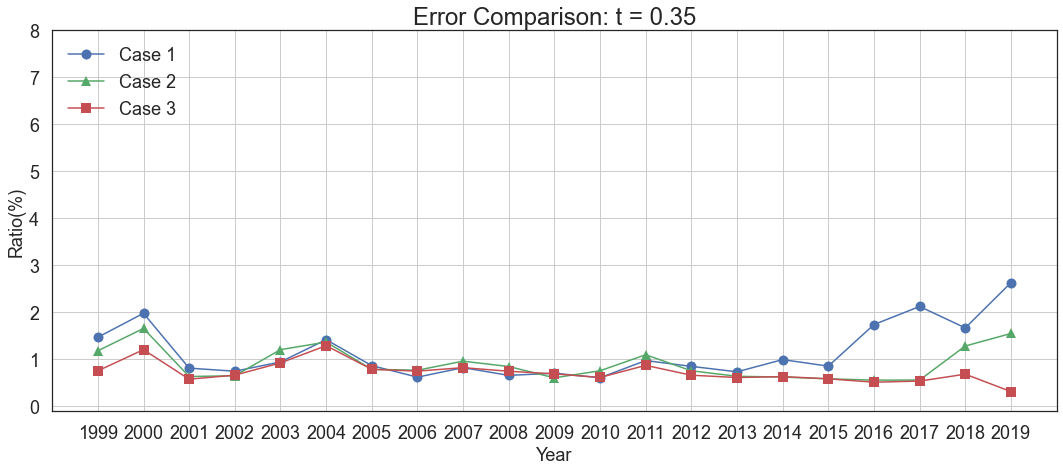

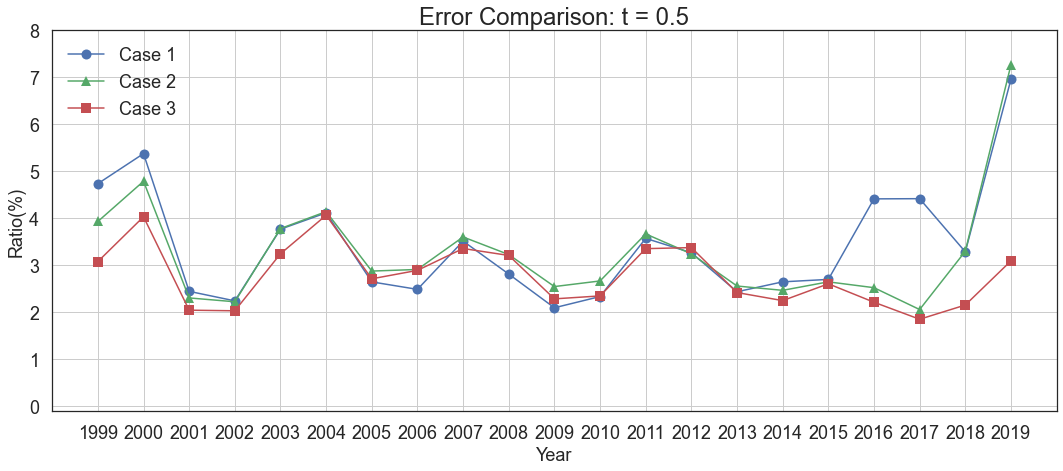

In [ ]:
sns.set(style = "white")

for df1, df2, df3, t in zip(case1, case2, case3, tt):
    
    fig,ax = plt.subplots(figsize = (18,7))
    plt.title('Error Comparison: t = '+ str(t),fontsize=24)
    ax.plot(range(1999,2020), df1.err_ratio*100, '-bo', markersize = 10, label = 'Case 1')
    ax.plot(range(1999,2020), df2.err_ratio*100, '-g^', markersize = 10, label = 'Case 2')
    ax.plot(range(1999,2020), df3.err_ratio*100, '-rs', markersize = 10, label = 'Case 3')    

    ax.set_xlabel('Year',fontsize=18)
    ax.set_ylabel('Ratio(%)',fontsize=18)
    ax.legend(fontsize = 18, loc = 'upper left')
    plt.xticks(range(1999,2020), fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(-0.1,8)
    plt.grid()
    plt.show()

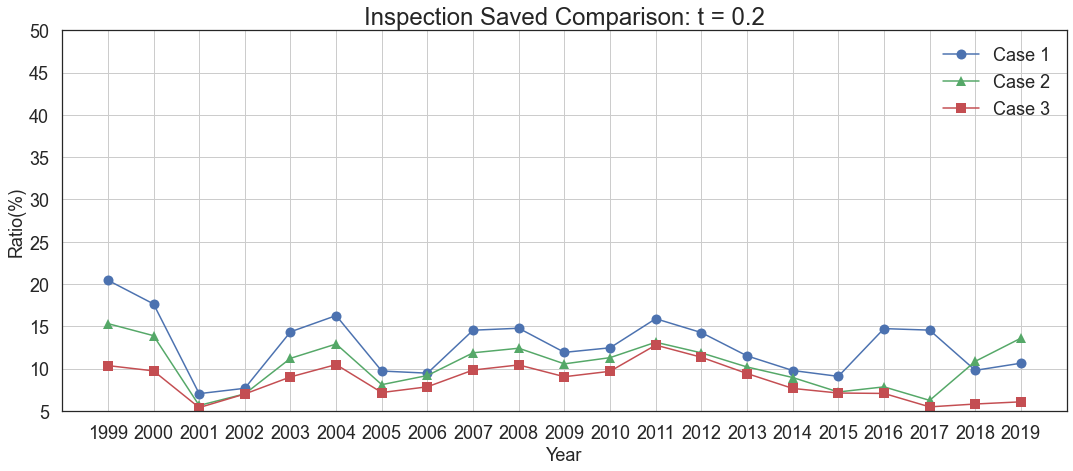

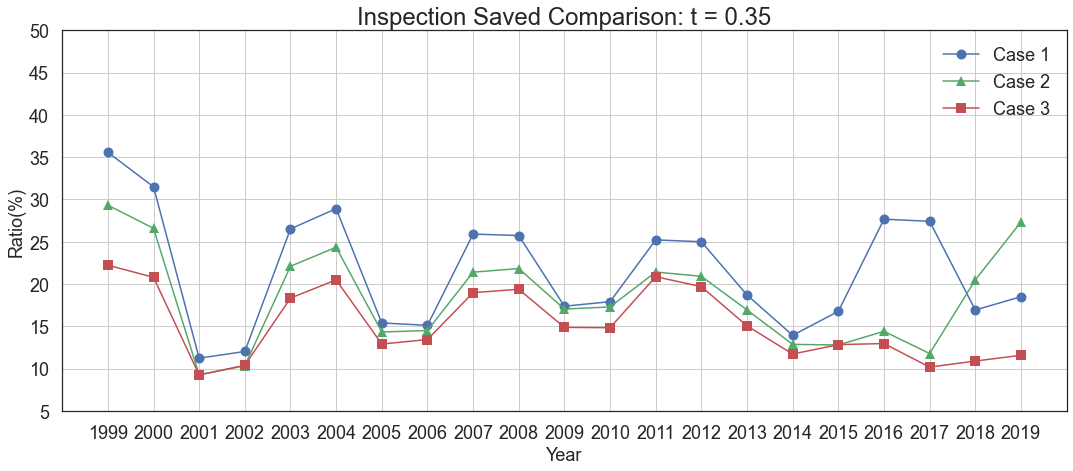

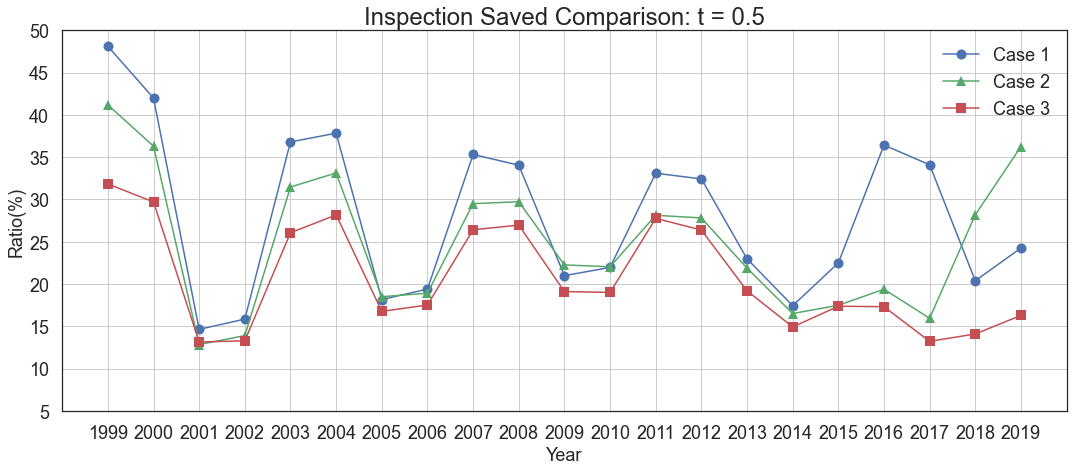

In [ ]:
sns.set(style = "white")

for df1, df2, df3, t in zip(case1, case2, case3, tt):
    
    fig,ax = plt.subplots(figsize = (18,7))
    plt.title('Inspection Saved Comparison: t = '+ str(t),fontsize=24)
    ax.plot(range(1999,2020), df1.inspection_saved_ratio*100, '-bo', markersize = 10, label = 'Case 1')
    ax.plot(range(1999,2020), df2.inspection_saved_ratio*100, '-g^', markersize = 10, label = 'Case 2')
    ax.plot(range(1999,2020), df3.inspection_saved_ratio*100, '-rs', markersize = 10, label = 'Case 3')

    ax.set_xlabel('Year',fontsize=18)
    ax.set_ylabel('Ratio(%)',fontsize=18)
    ax.legend(fontsize = 18, loc = 'upper right')
    plt.xticks(range(1999,2020), fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(5,50)
    plt.grid()
    plt.show()

### Case 1, 不同t

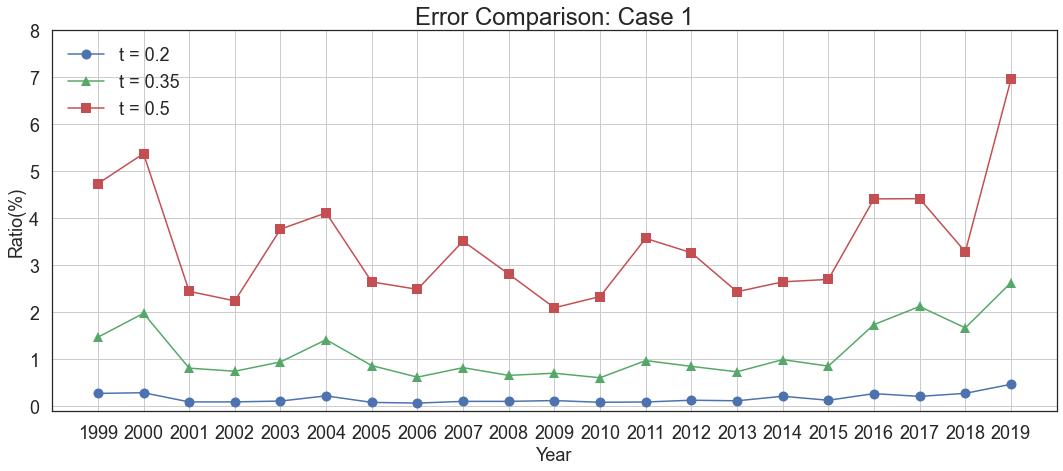

In [ ]:
sns.set(style = "white")
fig,ax = plt.subplots(figsize = (18,7))
plt.title('Error Comparison: Case 1',fontsize=24)
ax.plot(range(1999,2020), result_102.err_ratio*100, '-bo', markersize = 10, label = 't = 0.2')
ax.plot(range(1999,2020), result_1035.err_ratio*100, '-g^', markersize = 10, label = 't = 0.35')
ax.plot(range(1999,2020), result_105.err_ratio*100, '-rs', markersize = 10, label = 't = 0.5')

ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('Ratio(%)',fontsize=18)
ax.legend(fontsize = 18, loc = 'upper left')
plt.xticks(range(1999,2020), fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1,8)
plt.grid()
plt.show()

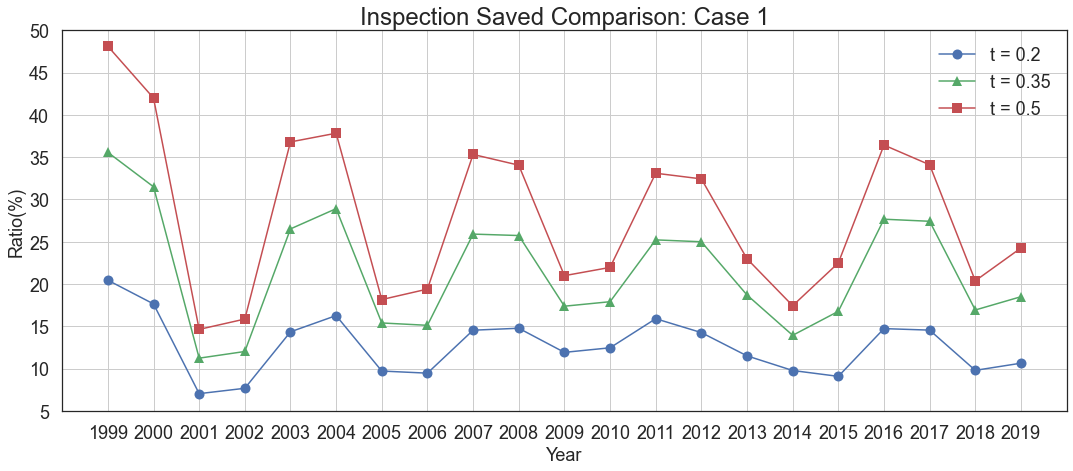

In [ ]:
sns.set(style = "white")
fig,ax = plt.subplots(figsize = (18,7))
plt.title('Inspection Saved Comparison: Case 1',fontsize=24)
ax.plot(range(1999,2020), result_102.inspection_saved_ratio*100, '-bo', markersize = 10, label = 't = 0.2')
ax.plot(range(1999,2020), result_1035.inspection_saved_ratio*100, '-g^', markersize = 10, label = 't = 0.35')
ax.plot(range(1999,2020), result_105.inspection_saved_ratio*100, '-rs', markersize = 10, label = 't = 0.5')

ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('Ratio(%)',fontsize=18)
ax.legend(fontsize = 18)
plt.xticks(range(1999,2020), fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(5,50)
plt.grid()
plt.show()

### Case 2, 不同t

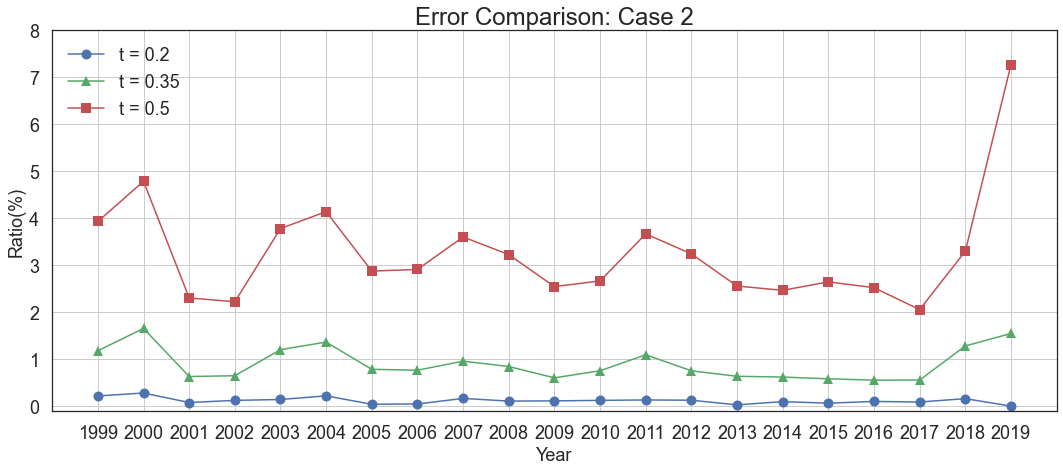

In [ ]:
sns.set(style = "white")
fig,ax = plt.subplots(figsize = (18,7))
plt.title('Error Comparison: Case 2',fontsize=24)
ax.plot(range(1999,2020), result_202.err_ratio*100, '-bo', markersize = 10, label = 't = 0.2')
ax.plot(range(1999,2020), result_2035.err_ratio*100, '-g^', markersize = 10, label = 't = 0.35')
ax.plot(range(1999,2020), result_205.err_ratio*100, '-rs', markersize = 10, label = 't = 0.5')

ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('Ratio(%)',fontsize=18)
ax.legend(fontsize = 18, loc = 'upper left')
plt.xticks(range(1999,2020), fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1,8)
plt.grid()
plt.show()

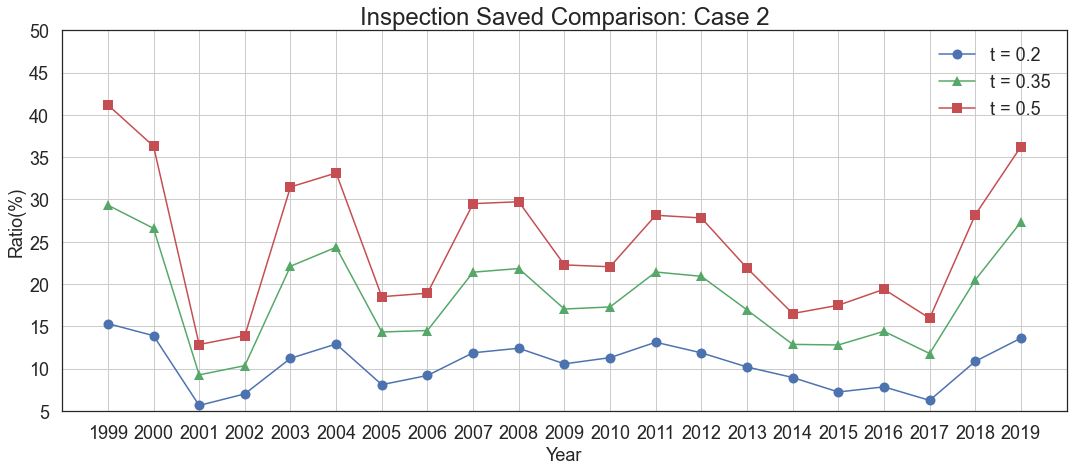

In [ ]:
sns.set(style = "white")
fig,ax = plt.subplots(figsize = (18,7))
plt.title('Inspection Saved Comparison: Case 2',fontsize=24)
ax.plot(range(1999,2020), result_202.inspection_saved_ratio*100, '-bo', markersize = 10, label = 't = 0.2')
ax.plot(range(1999,2020), result_2035.inspection_saved_ratio*100, '-g^', markersize = 10, label = 't = 0.35')
ax.plot(range(1999,2020), result_205.inspection_saved_ratio*100, '-rs', markersize = 10, label = 't = 0.5')

ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('Ratio(%)',fontsize=18)
ax.legend(fontsize = 18)
plt.xticks(range(1999,2020), fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(5,50)
plt.grid()
plt.show()

### Case 3, 不同t

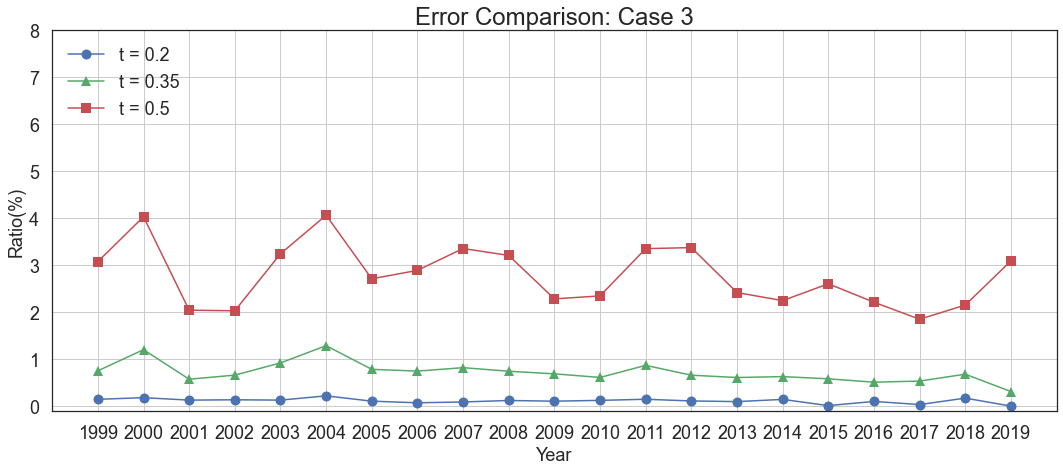

In [ ]:
sns.set(style = "white")
fig,ax = plt.subplots(figsize = (18,7))
plt.title('Error Comparison: Case 3',fontsize=24)
ax.plot(range(1999,2020), result_302.err_ratio*100, '-bo', markersize = 10, label = 't = 0.2')
ax.plot(range(1999,2020), result_3035.err_ratio*100, '-g^', markersize = 10, label = 't = 0.35')
ax.plot(range(1999,2020), result_305.err_ratio*100, '-rs', markersize = 10, label = 't = 0.5')

ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('Ratio(%)',fontsize=18)
ax.legend(fontsize = 18, loc = 'upper left')
plt.xticks(range(1999,2020), fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1,8)
plt.grid()
plt.show()

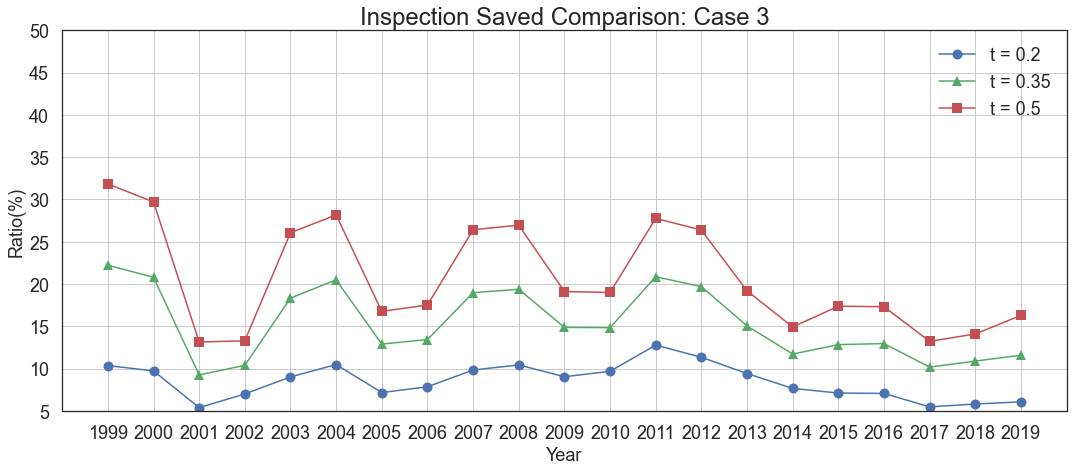

In [ ]:
sns.set(style = "white")
fig,ax = plt.subplots(figsize = (18,7))
plt.title('Inspection Saved Comparison: Case 3',fontsize=24)
ax.plot(range(1999,2020), result_302.inspection_saved_ratio*100, '-bo', markersize = 10, label = 't = 0.2')
ax.plot(range(1999,2020), result_3035.inspection_saved_ratio*100, '-g^', markersize = 10, label = 't = 0.35')
ax.plot(range(1999,2020), result_305.inspection_saved_ratio*100, '-rs', markersize = 10, label = 't = 0.5')

ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('Ratio(%)',fontsize=18)
ax.legend(fontsize = 18)
plt.xticks(range(1999,2020), fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(5,50)
plt.grid()
plt.show()

## 驗證

### 挑一座真的檢修過的橋